# Análise Exploratória de Dados (EDA) - Detecção de Ataques de Rede

## 📡 Sobre a Coleta dos Dados

**Este dataset foi coletado manualmente em ambiente controlado para garantir a fidelidade dos cenários de rede:**

### 🔬 Metodologia de Coleta
- **Ambiente**: Rede local controlada para reprodução experimental
- **Ferramentas**: Sniffers de rede (Wireshark, tcpdump) para captura de tráfego
- **Tráfego Normal**: Capturado durante uso típico de rede (navegação, downloads, comunicação)
- **Tráfego de Ataque**: Ataques executados manualmente para simular cenários reais

### ⚙️ Cenários Reproduzidos
- **Ataques Manuais**: Executados por especialistas para garantir padrões realistas
- **Condições Controladas**: Ambiente isolado para evitar interferências
- **Diversidade de Ataques**: Múltiplos tipos de ataques para variedade no dataset
- **Reprodutibilidade**: Metodologia documentada para replicação do experimento

### 🎯 Objetivo
Criar um dataset representativo que reflita padrões reais de tráfego de rede, permitindo o desenvolvimento de modelos de detecção de intrusão eficazes em ambientes similares.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("📊 Iniciando Análise Exploratória de Dados")
print("🔬 Dataset: Tráfego de rede coletado manualmente em ambiente controlado")

📊 Iniciando Análise Exploratória de Dados
🔬 Dataset: Tráfego de rede coletado manualmente em ambiente controlado


In [5]:
# 1. CARREGAMENTO E VISÃO GERAL DOS DADOS

# Carregamento dos dados processados
df = pd.read_csv('../data/processed/flows.csv')

print(f"✅ Dados carregados com sucesso!")
print(f"📈 Dimensões do dataset: {df.shape[0]} fluxos, {df.shape[1]} features")
print(f"🔍 Primeiras linhas:")
display(df.head())

✅ Dados carregados com sucesso!
📈 Dimensões do dataset: 2380 fluxos, 11 features
🔍 Primeiras linhas:


,src,dst,proto,sport,dport,bytes,pkts,duration,iat_mean,iat_std,label
0,34.36.152.253,192.168.15.2,TLS,443.0,41184.0,8936,94,90.008579,0.967834,0.177361,0
1,192.168.15.2,34.36.152.253,TCP,41184.0,443.0,6246,95,90.008565,0.957538,0.191871,0
2,192.168.15.20,255.255.255.255,DATA,6537.0,6537.0,28784,112,297.303076,2.678406,2.509676,0
3,2804:1b0:1900:9955:2347:6deb:7171:e846,2a03:2880:f205:c5:face:b00c:0:167,TLS,39212.0,443.0,9686,38,293.393077,7.929543,8.277250,0
4,2a03:2880:f205:c5:face:b00c:0:167,2804:1b0:1900:9955:2347:6deb:7171:e846,TCP,443.0,39212.0,3268,38,293.394744,7.929588,8.277502,0


In [6]:
# 2. ESTRUTURA E TIPOS DE DADOS

print("🔬 Informações sobre os dados:")
print(f"📊 Formato: {df.shape}")
print(f"💾 Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

print("📋 Tipos de dados:")
display(df.dtypes.to_frame('Tipo'))
print()

print("❌ Valores ausentes:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Ausentes': missing,
    'Percentual (%)': missing_pct
}).round(2)
display(missing_df[missing_df['Valores Ausentes'] > 0])

🔬 Informações sobre os dados:
📊 Formato: (2380, 11)
💾 Memória utilizada: 0.63 MB

📋 Tipos de dados:


,Tipo
src,object
dst,object
proto,object
sport,float64
dport,float64
bytes,int64
pkts,int64
duration,float64
iat_mean,float64
iat_std,float64



❌ Valores ausentes:


,Valores Ausentes,Percentual (%)
sport,28,1.18
dport,28,1.18
iat_std,979,41.13


In [7]:
# 3. ESTATÍSTICAS DESCRITIVAS E TESTES DE HIPÓTESE

print("📈 Resumo estatístico das features numéricas:")
numeric_cols = ['bytes', 'pkts', 'duration', 'iat_mean', 'iat_std']
desc_stats = df[numeric_cols + ['label']].describe()
display(desc_stats.round(4))

print()
print("🎯 Estatísticas por classe (Normal vs Ataque):")
stats_by_label = df.groupby('label')[numeric_cols].describe()
display(stats_by_label.round(4))

# Consumo de memória
memory_usage = df.memory_usage(deep=True).sum() / 1024**2
print(f"\n💾 Consumo de memória do DataFrame: {memory_usage:.2f} MB")

# Testes de hipótese para comparar distribuições entre classes
print("\n🔬 Testes Estatísticos (Normal vs Ataque):")
print("=" * 60)

from scipy.stats import mannwhitneyu, ks_2samp

hypothesis_results = []

for col in numeric_cols:
    normal_data = df[df['label'] == 0][col].dropna()
    attack_data = df[df['label'] == 1][col].dropna()
    
    # Teste de Mann-Whitney U (não paramétrico)
    mw_stat, mw_p = mannwhitneyu(normal_data, attack_data, alternative='two-sided')
    
    # Teste de Kolmogorov-Smirnov (distribuições)
    ks_stat, ks_p = ks_2samp(normal_data, attack_data)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(normal_data) - 1) * normal_data.var() + 
                          (len(attack_data) - 1) * attack_data.var()) / 
                         (len(normal_data) + len(attack_data) - 2))
    cohens_d = (attack_data.mean() - normal_data.mean()) / pooled_std
    
    hypothesis_results.append({
        'Feature': col,
        'Mann_Whitney_U': mw_stat,
        'MW_p_value': mw_p,
        'MW_Significativo': 'Sim' if mw_p < 0.05 else 'Não',
        'KS_statistic': ks_stat,
        'KS_p_value': ks_p,
        'KS_Significativo': 'Sim' if ks_p < 0.05 else 'Não',
        'Cohens_d': cohens_d,
        'Effect_Size': 'Pequeno' if abs(cohens_d) < 0.5 else 'Médio' if abs(cohens_d) < 0.8 else 'Grande'
    })

hypothesis_df = pd.DataFrame(hypothesis_results)
display(hypothesis_df.round(4))

print("\n🔍 Interpretação dos Testes:")
print("• Mann-Whitney U: Testa se as medianas são diferentes (não paramétrico)")
print("• Kolmogorov-Smirnov: Testa se as distribuições são diferentes")
print("• Cohen's d: Mede o tamanho do efeito (diferença padronizada)")
print("  - |d| < 0.5: Efeito pequeno")
print("  - 0.5 ≤ |d| < 0.8: Efeito médio") 
print("  - |d| ≥ 0.8: Efeito grande")

# Resumo das features mais discriminativas
significant_features = hypothesis_df[
    (hypothesis_df['MW_Significativo'] == 'Sim') & 
    (hypothesis_df['KS_Significativo'] == 'Sim')
]['Feature'].tolist()

print(f"\n⭐ Features estatisticamente significativas: {len(significant_features)}/{len(numeric_cols)}")
for feature in significant_features:
    effect = hypothesis_df[hypothesis_df['Feature'] == feature]['Effect_Size'].iloc[0]
    cohens = hypothesis_df[hypothesis_df['Feature'] == feature]['Cohens_d'].iloc[0]
    print(f"  • {feature}: {effect} efeito (d = {cohens:.3f})")

if len(significant_features) < len(numeric_cols):
    non_significant = [f for f in numeric_cols if f not in significant_features]
    print(f"\n⚠️ Features sem diferença significativa: {non_significant}")
    print("   Considere removê-las ou combiná-las para melhorar o modelo")

📈 Resumo estatístico das features numéricas:


,bytes,pkts,duration,iat_mean,iat_std,label
count,2.380000e+03,2380.0000,2380.0000,2380.0000,1401.0000,2380.0000
mean,1.997178e+04,24.0571,26.8724,3.8856,8.2454,0.0622
std,2.740212e+05,209.6920,55.1631,11.0839,11.9042,0.2415
min,4.600000e+01,1.0000,0.0000,0.0000,0.0000,0.0000
25%,2.020000e+02,2.0000,0.0002,0.0002,0.0339,0.0000
50%,8.680000e+02,5.0000,0.1618,0.0233,1.3747,0.0000
75%,3.147750e+03,10.0000,11.7793,0.9512,19.2489,0.0000
max,1.146562e+07,8304.0000,297.3031,127.8720,64.6156,1.0000



🎯 Estatísticas por classe (Normal vs Ataque):


bytes                                                       \
        count        mean          std   min    25%    50%     75%   
label                                                                
0      2232.0  21152.2536  282920.0808  60.0  204.0  876.5  3174.0   
1       148.0   2168.9865    6235.4819  46.0  182.0  375.0  2223.0   

                     pkts           ... iat_mean           iat_std          \
              max   count     mean  ...      75%       max   count    mean   
label                               ...                                      
0      11465618.0  2232.0  25.1918  ...   0.8545  127.8720  1328.0  8.3249   
1         67298.0   148.0   6.9459  ...   6.5589   60.0025    73.0  6.7990   

                                                       
           std  min     25%     50%      75%      max  
label                                                  
0      12.0373  0.0  0.0328  1.1400  20.0213  64.6156  
1       9.0955  0.0  0.1089  2.9527   7.4644  34.6595  

[2 rows x 40 columns]


💾 Consumo de memória do DataFrame: 0.63 MB

🔬 Testes Estatísticos (Normal vs Ataque):


,Feature,Mann_Whitney_U,MW_p_value,MW_Significativo,KS_statistic,KS_p_value,KS_Significativo,Cohens_d,Effect_Size
0,bytes,193965.0,0.0004,Sim,0.2041,0.0000,Sim,-0.0693,Pequeno
1,pkts,195165.0,0.0001,Sim,0.1862,0.0001,Sim,-0.0870,Pequeno
2,duration,160143.0,0.5348,Não,0.1471,0.0044,Sim,-0.0076,Pequeno
3,iat_mean,148052.5,0.0345,Sim,0.1723,0.0004,Sim,0.3867,Pequeno
4,iat_std,46290.0,0.5169,Não,0.1749,0.0254,Sim,-0.1282,Pequeno



🔍 Interpretação dos Testes:
• Mann-Whitney U: Testa se as medianas são diferentes (não paramétrico)
• Kolmogorov-Smirnov: Testa se as distribuições são diferentes
• Cohen's d: Mede o tamanho do efeito (diferença padronizada)
  - |d| < 0.5: Efeito pequeno
  - 0.5 ≤ |d| < 0.8: Efeito médio
  - |d| ≥ 0.8: Efeito grande

⭐ Features estatisticamente significativas: 3/5
  • bytes: Pequeno efeito (d = -0.069)
  • pkts: Pequeno efeito (d = -0.087)
  • iat_mean: Pequeno efeito (d = 0.387)

⚠️ Features sem diferença significativa: ['duration', 'iat_std']
   Considere removê-las ou combiná-las para melhorar o modelo


⚖️ Distribuição das classes:


,Classe,Quantidade,Proporção (%)
0,Normal (0),2232,93.78
1,Ataque (1),148,6.22


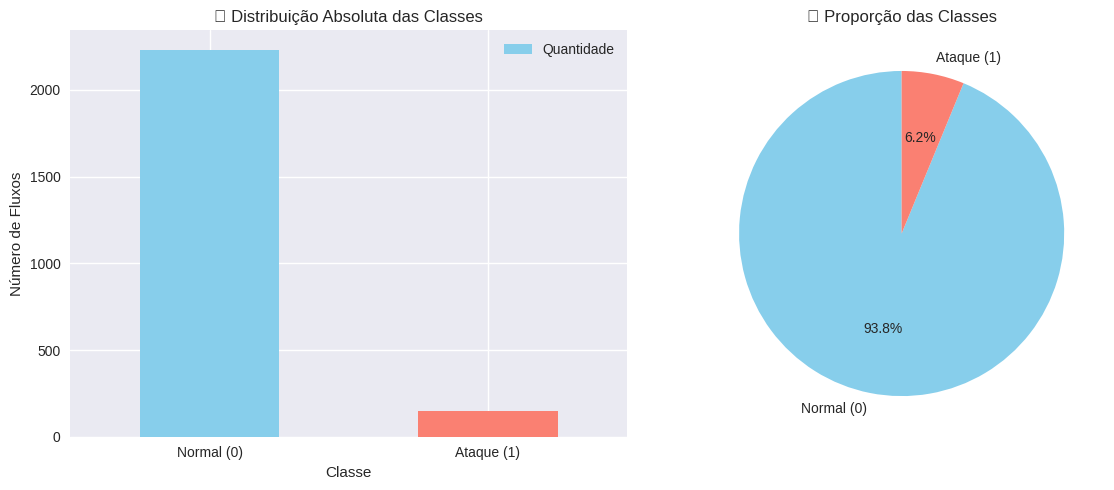

📊 Proporção Ataque/Normal: 0.066
⚠️  Dataset muito desbalanceado - considere técnicas de balanceamento


In [8]:
# 4. ANÁLISE DE BALANCEAMENTO DAS CLASSES

print("⚖️ Distribuição das classes:")
label_counts = df['label'].value_counts().sort_index()
label_props = df['label'].value_counts(normalize=True).sort_index()

balance_df = pd.DataFrame({
    'Classe': ['Normal (0)', 'Ataque (1)'],
    'Quantidade': label_counts.values,
    'Proporção (%)': (label_props.values * 100).round(2)
})

display(balance_df)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
balance_df.plot(x='Classe', y='Quantidade', kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('📊 Distribuição Absoluta das Classes')
ax1.set_xlabel('Classe')
ax1.set_ylabel('Número de Fluxos')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pizza
ax2.pie(balance_df['Quantidade'], labels=balance_df['Classe'], autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('🥧 Proporção das Classes')

plt.tight_layout()
plt.show()

# Análise de balanceamento
ratio = label_counts.iloc[1] / label_counts.iloc[0]
print(f"📊 Proporção Ataque/Normal: {ratio:.3f}")
if ratio < 0.1:
    print("⚠️  Dataset muito desbalanceado - considere técnicas de balanceamento")
elif ratio < 0.5:
    print("⚠️  Dataset moderadamente desbalanceado")
else:
    print("✅ Dataset relativamente balanceado")

📊 Analisando distribuições das features numéricas...
🔢 Processando 5 features numéricas
🔄 Processando feature 1/5: bytes
🔄 Processando feature 2/5: pkts
🔄 Processando feature 3/5: duration
🔄 Processando feature 4/5: iat_mean
🔄 Processando feature 5/5: iat_std


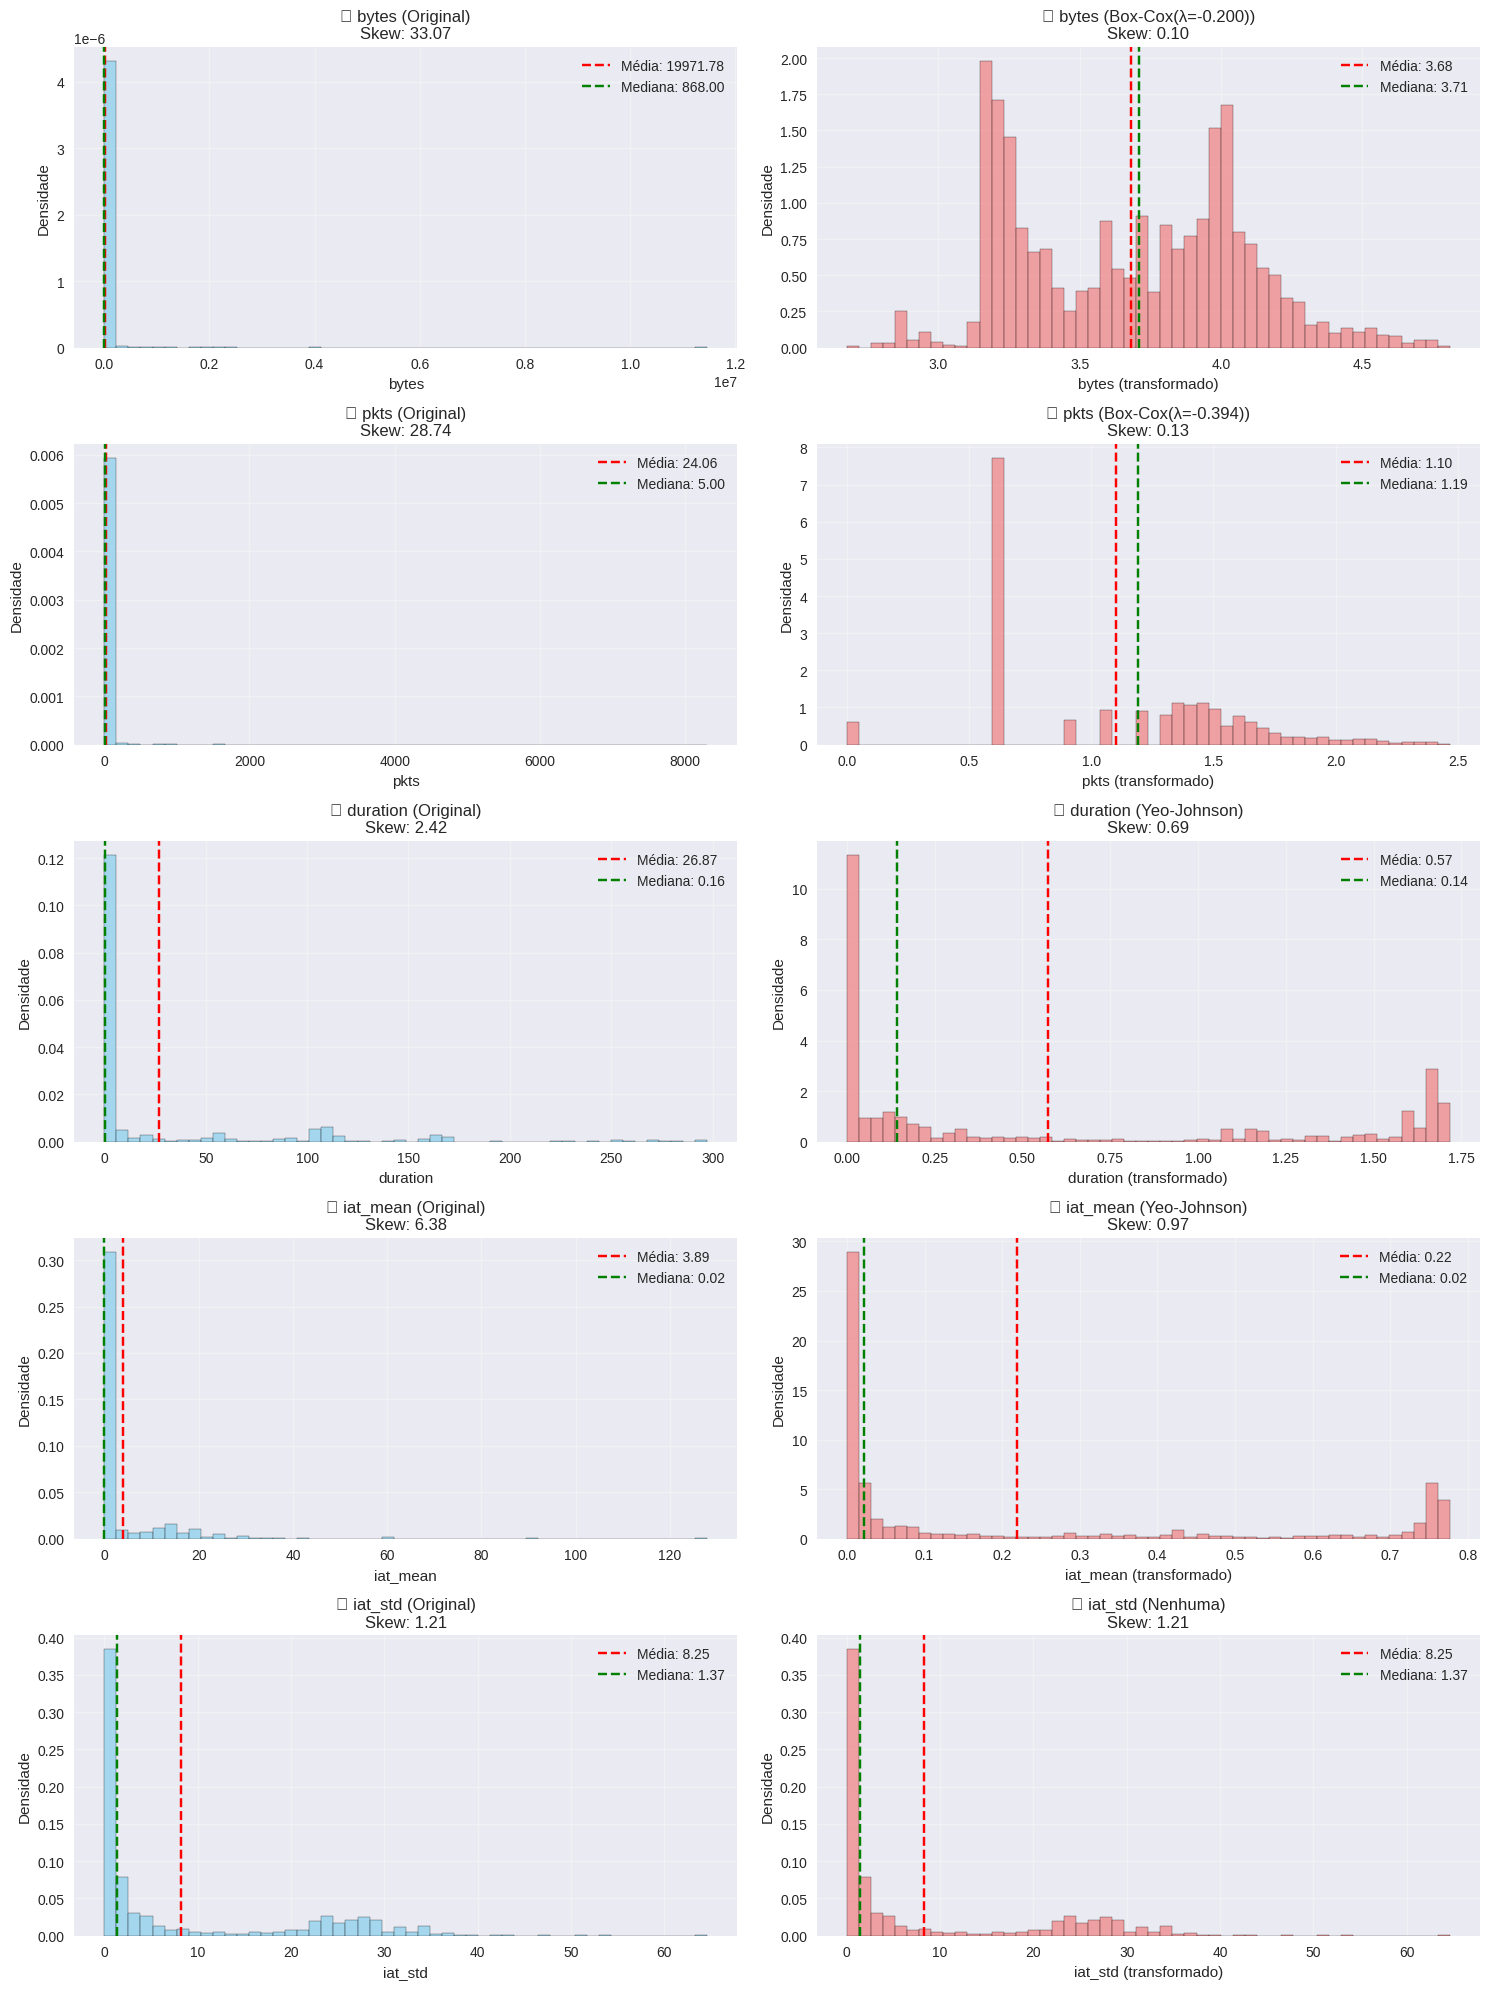


🔄 Resumo das Transformações Recomendadas:


,Feature,Skew_Original,Normalidade_Original,Transformação_Recomendada,Skew_Transformado,Normalidade_Transformada,Melhoria_Skew
0,bytes,33.069,Não Normal,Box-Cox(λ=-0.200),0.097,Não Normal,32.971
1,pkts,28.738,Não Normal,Box-Cox(λ=-0.394),0.128,Não Normal,28.610
2,duration,2.415,Não Normal,Yeo-Johnson,0.689,Não Normal,1.726
3,iat_mean,6.385,Não Normal,Yeo-Johnson,0.971,Não Normal,5.414
4,iat_std,1.209,Não Normal,Nenhuma,1.209,Não Normal,0.000



💡 Recomendações para Pré-processamento:
⚠️ Features com alta assimetria (|skew| > 1):
  • bytes: Box-Cox(λ=-0.200) - ✅ Melhorou
    Skew: 33.07 → 0.10
  • pkts: Box-Cox(λ=-0.394) - ✅ Melhorou
    Skew: 28.74 → 0.13
  • duration: Yeo-Johnson - ✅ Melhorou
    Skew: 2.42 → 0.69
  • iat_mean: Yeo-Johnson - ✅ Melhorou
    Skew: 6.38 → 0.97
  • iat_std: Nenhuma - ⚠️ Pouca melhoria
    Skew: 1.21 → 1.21

🎯 Estratégia para Autoencoder:
• Features com skew > 2: Aplicar transformação antes da normalização
• Features normalizadas: StandardScaler ou MinMaxScaler
• Manter transformações inversíveis para interpretação dos resultados

✅ Seção 5 executada com sucesso!


In [9]:

# 5. DISTRIBUIÇÕES UNIVARIADAS E ANÁLISE DE TRANSFORMAÇÕES

print("📊 Analisando distribuições das features numéricas...")

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# ✅ CORREÇÃO 1: Ajustar dinâmicamente o número de subplots
n_features = len(numeric_cols)
print(f"🔢 Processando {n_features} features numéricas")

# ✅ CORREÇÃO 2: Subplot dinâmico baseado no número real de features
fig, axes = plt.subplots(n_features, 2, figsize=(15, 4*n_features))

# ✅ CORREÇÃO 3: Garantir que axes seja sempre bidimensional
if n_features == 1:
    axes = axes.reshape(1, -1)

transformation_results = []

for i, col in enumerate(numeric_cols):
    print(f"🔄 Processando feature {i+1}/{n_features}: {col}")
    
    # ✅ CORREÇÃO 4: Usar indexação 2D ao invés de ravel
    # Plot original (primeira coluna)
    axes[i, 0].hist(df[col], bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    
    # Estatísticas da distribuição original
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = df[col].skew()
    
    # Linhas de referência
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', label=f'Média: {mean_val:.2f}')
    axes[i, 0].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.2f}')
    
    axes[i, 0].set_title(f'📈 {col} (Original)\nSkew: {skew_val:.2f}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Densidade')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Teste de normalidade original
    _, p_value_orig = stats.normaltest(df[col].dropna())
    normality_orig = "Normal" if p_value_orig > 0.05 else "Não Normal"
    
    # Aplicar transformação se skew > 1
    best_transformation = "Nenhuma"
    transformed_data = df[col].copy()
    skew_transformed = skew_val
    normality_transformed = normality_orig
    
    if abs(skew_val) > 1:
        # Testar diferentes transformações
        transformations = {}
        
        # Log transform (apenas para valores positivos)
        if (df[col] > 0).all():
            log_data = np.log1p(df[col])  # log(1+x) para evitar log(0)
            transformations['Log(1+x)'] = log_data
        
        # Square root transform (apenas para valores não negativos)
        if (df[col] >= 0).all():
            sqrt_data = np.sqrt(df[col])
            transformations['Sqrt'] = sqrt_data
        
        # Box-Cox transform (apenas para valores positivos)
        if (df[col] > 0).all():
            try:
                boxcox_data, lambda_param = boxcox(df[col])
                transformations[f'Box-Cox(λ={lambda_param:.3f})'] = boxcox_data
            except:
                pass
        
        # Yeo-Johnson transform (aceita valores negativos)
        try:
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            yj_data = pt.fit_transform(df[col].values.reshape(-1, 1)).flatten()
            transformations['Yeo-Johnson'] = yj_data
        except:
            pass
        
        # Escolher a melhor transformação (menor skew absoluto)
        if transformations:
            best_skew = float('inf')
            for transform_name, transform_data in transformations.items():
                current_skew = abs(stats.skew(transform_data))
                if current_skew < best_skew:
                    best_skew = current_skew
                    best_transformation = transform_name
                    transformed_data = transform_data
                    skew_transformed = stats.skew(transform_data)
    
    # ✅ CORREÇÃO 5: Plot transformado (segunda coluna)
    axes[i, 1].hist(transformed_data, bins=50, alpha=0.7, density=True, 
                    color='lightcoral', edgecolor='black')
    
    # ✅ CORREÇÃO 6: Tratamento robusto de tipos de dados
    if isinstance(transformed_data, (pd.Series, pd.DataFrame)):
        mean_trans = transformed_data.mean()
        median_trans = transformed_data.median()
    else:
        mean_trans = np.mean(transformed_data)
        median_trans = np.median(transformed_data)
    
    axes[i, 1].axvline(mean_trans, color='red', linestyle='--', label=f'Média: {mean_trans:.2f}')
    axes[i, 1].axvline(median_trans, color='green', linestyle='--', label=f'Mediana: {median_trans:.2f}')
    
    # Teste de normalidade transformado
    if best_transformation != "Nenhuma":
        try:
            if isinstance(transformed_data, (pd.Series, pd.DataFrame)):
                test_data = transformed_data.dropna()
            else:
                test_data = pd.Series(transformed_data).dropna()
            _, p_value_trans = stats.normaltest(test_data)
            normality_transformed = "Normal" if p_value_trans > 0.05 else "Não Normal"
        except:
            normality_transformed = "Erro no teste"
    
    axes[i, 1].set_title(f'🔄 {col} ({best_transformation})\nSkew: {skew_transformed:.2f}')
    axes[i, 1].set_xlabel(f'{col} (transformado)')
    axes[i, 1].set_ylabel('Densidade')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    
    # Armazenar resultados
    transformation_results.append({
        'Feature': col,
        'Skew_Original': skew_val,
        'Normalidade_Original': normality_orig,
        'Transformação_Recomendada': best_transformation,
        'Skew_Transformado': skew_transformed,
        'Normalidade_Transformada': normality_transformed,
        'Melhoria_Skew': abs(skew_val) - abs(skew_transformed)
    })

plt.tight_layout()
plt.show()

# Resumo das transformações
transformation_df = pd.DataFrame(transformation_results)
print("\n🔄 Resumo das Transformações Recomendadas:")
display(transformation_df.round(3))

print("\n💡 Recomendações para Pré-processamento:")
high_skew_features = transformation_df[abs(transformation_df['Skew_Original']) > 1]
if len(high_skew_features) > 0:
    print("⚠️ Features com alta assimetria (|skew| > 1):")
    for _, row in high_skew_features.iterrows():
        improvement = "✅ Melhorou" if row['Melhoria_Skew'] > 0.5 else "⚠️ Pouca melhoria"
        print(f"  • {row['Feature']}: {row['Transformação_Recomendada']} - {improvement}")
        print(f"    Skew: {row['Skew_Original']:.2f} → {row['Skew_Transformado']:.2f}")
else:
    print("✅ Todas as features têm assimetria aceitável")

print("\n🎯 Estratégia para Autoencoder:")
print("• Features com skew > 2: Aplicar transformação antes da normalização")
print("• Features normalizadas: StandardScaler ou MinMaxScaler")
print("• Manter transformações inversíveis para interpretação dos resultados")

print("\n✅ Seção 5 executada com sucesso!")


🎯 Comparando distribuições entre classes Normal e Ataque...


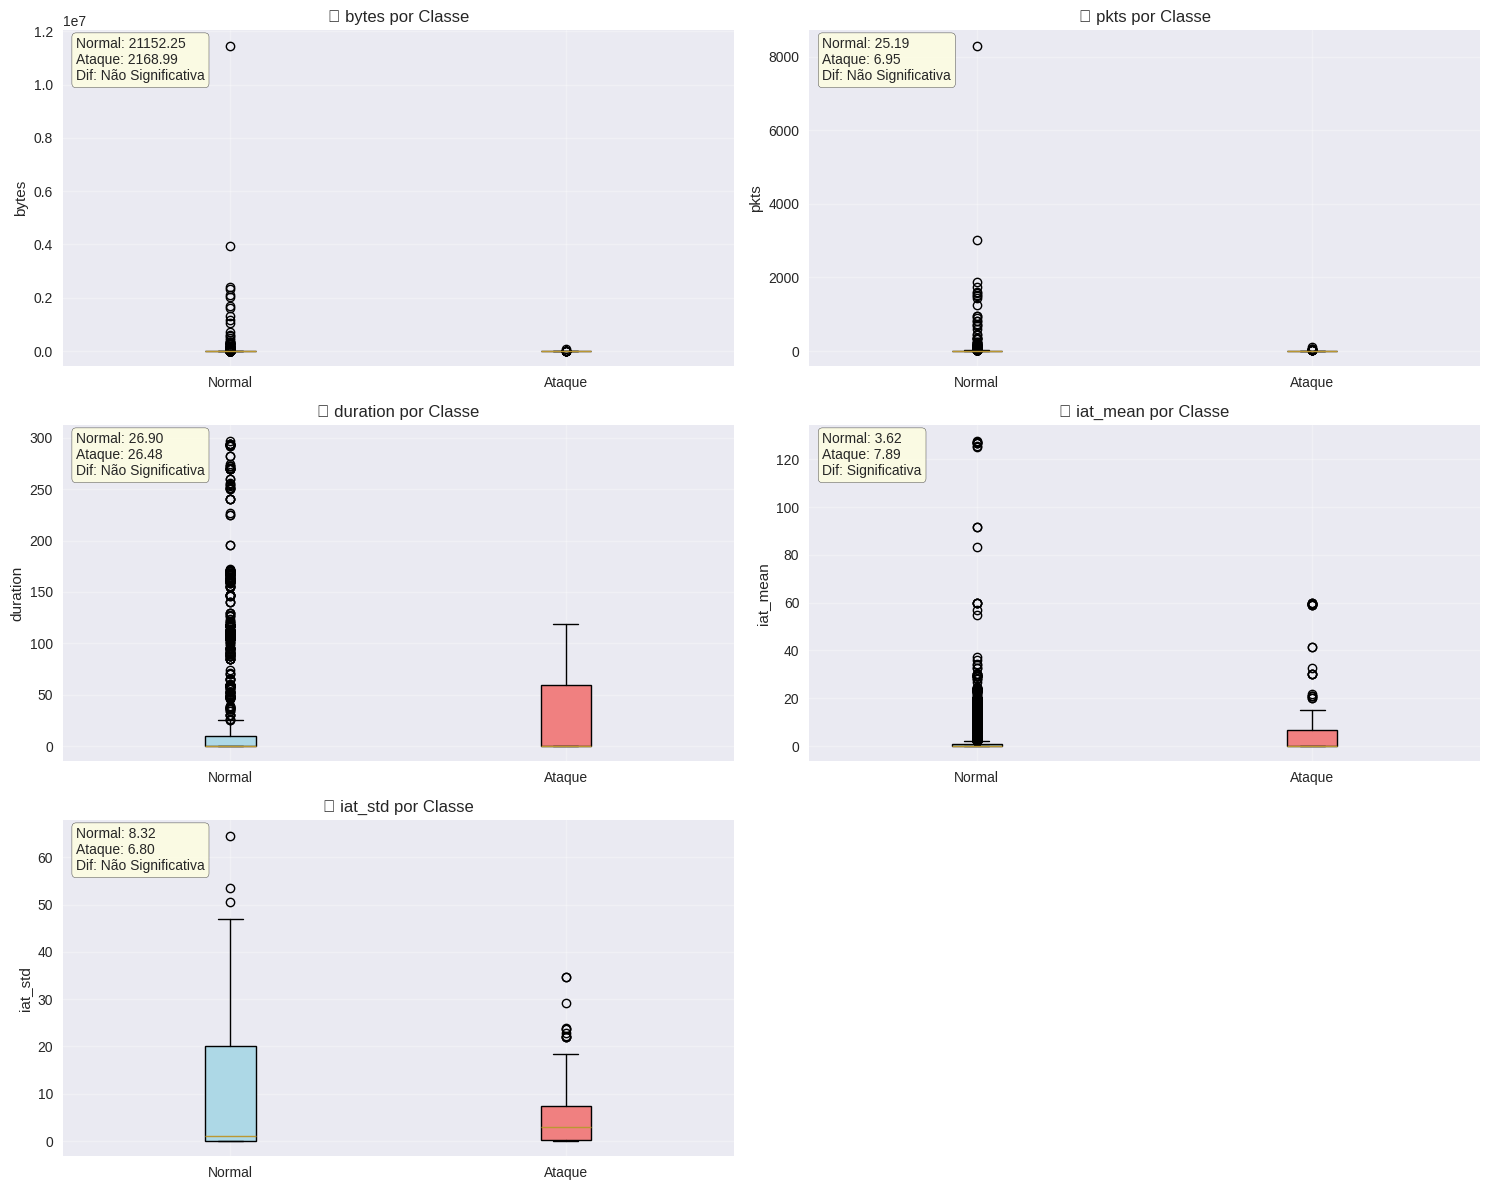


📊 Resumo das diferenças entre classes:


,Feature,Normal_Mean,Attack_Mean,Diferença_%,P_Value,Effect_Size
0,bytes,21152.2536,2168.9865,-89.7458,0.4145,-0.0693
1,pkts,25.1918,6.9459,-72.4277,0.3054,-0.0870
2,duration,26.8985,26.4784,-1.5619,0.9285,-0.0076
3,iat_mean,3.6202,7.8885,117.9057,0.0000,0.3851
4,iat_std,8.3249,6.7990,-18.3293,0.2865,-0.1282



🔍 Features mais discriminativas (por tamanho do efeito):
• iat_mean: Effect Size = 0.385
• iat_std: Effect Size = -0.128
• pkts: Effect Size = -0.087


In [10]:
# 6. ANÁLISE COMPARATIVA POR CLASSE (NORMAL VS ATAQUE)

print("🎯 Comparando distribuições entre classes Normal e Ataque...")

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # Boxplot comparativo
    box_data = [df[df['label'] == 0][col].dropna(), df[df['label'] == 1][col].dropna()]
    box = axes[i].boxplot(box_data, labels=['Normal', 'Ataque'], patch_artist=True)
    
    # Colorir as caixas
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'📦 {col} por Classe')
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    
    # Estatísticas comparativas
    normal_mean = df[df['label'] == 0][col].mean()
    attack_mean = df[df['label'] == 1][col].mean()
    
    # Teste t para diferença de médias
    _, p_value = stats.ttest_ind(
        df[df['label'] == 0][col].dropna(), 
        df[df['label'] == 1][col].dropna()
    )
    
    significance = "Significativa" if p_value < 0.05 else "Não Significativa"
    
    axes[i].text(0.02, 0.98, 
                f'Normal: {normal_mean:.2f}\nAtaque: {attack_mean:.2f}\nDif: {significance}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# Remove o subplot extra
if len(numeric_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Análise quantitativa das diferenças
print("\n📊 Resumo das diferenças entre classes:")
comparison_stats = []

for col in numeric_cols:
    normal_data = df[df['label'] == 0][col]
    attack_data = df[df['label'] == 1][col]
    
    _, p_value = stats.ttest_ind(normal_data.dropna(), attack_data.dropna())
    effect_size = (attack_data.mean() - normal_data.mean()) / df[col].std()
    
    comparison_stats.append({
        'Feature': col,
        'Normal_Mean': normal_data.mean(),
        'Attack_Mean': attack_data.mean(),
        'Diferença_%': ((attack_data.mean() - normal_data.mean()) / normal_data.mean() * 100),
        'P_Value': p_value,
        'Effect_Size': effect_size
    })

comparison_df = pd.DataFrame(comparison_stats)
display(comparison_df.round(4))

print("\n🔍 Features mais discriminativas (por tamanho do efeito):")
top_features = comparison_df.reindex(comparison_df['Effect_Size'].abs().sort_values(ascending=False).index)
for _, row in top_features.head(3).iterrows():
    print(f"• {row['Feature']}: Effect Size = {row['Effect_Size']:.3f}")

🔗 Analisando correlações entre features...


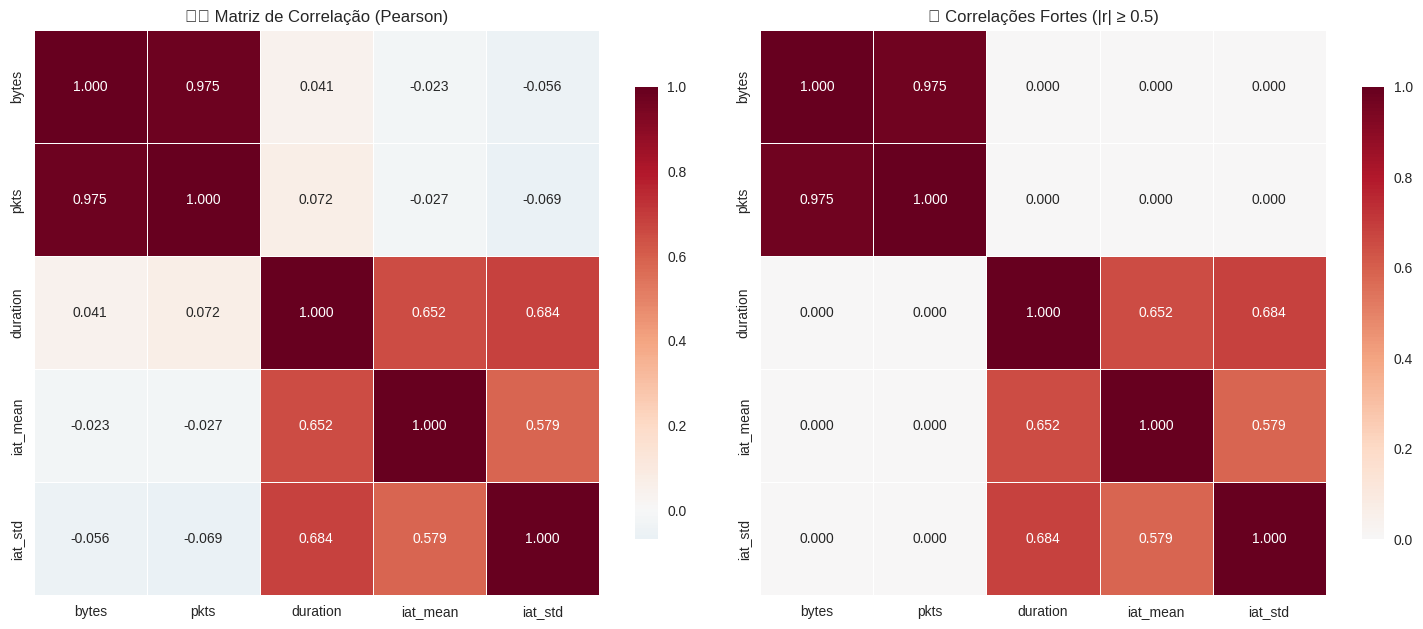


📈 Correlações mais fortes entre features:
Top 5 correlações mais fortes:


,Feature_1,Feature_2,Correlação,Magnitude
0,bytes,pkts,0.975,0.975
8,duration,iat_std,0.684,0.684
7,duration,iat_mean,0.652,0.652
9,iat_mean,iat_std,0.579,0.579
4,pkts,duration,0.072,0.072



⚠️ Análise de Multicolinearidade (baseada em correlações):
🔥 Correlações Extremas (|r| > 0.9): 1 pares
Features com correlação quase perfeita:
• bytes ↔ pkts: 0.975 (positiva)

💡 Recomendações:
• Remover uma das features em cada par altamente correlacionado
• Ou combinar usando PCA ou média ponderada
• Para autoencoders, alta correlação causa redundância

🔶 Correlações Fortes (0.7 ≤ |r| < 0.9): 0 pares

🔸 Correlações Moderadas (0.5 ≤ |r| < 0.7): 3 pares
• duration ↔ iat_std: 0.684 (positiva)
• duration ↔ iat_mean: 0.652 (positiva)
• iat_mean ↔ iat_std: 0.579 (positiva)

📊 Resumo de Multicolinearidade:
• Pares extremamente correlacionados (|r| > 0.9): 1
• Pares fortemente correlacionados (0.7 ≤ |r| < 0.9): 0
• Total de pares problemáticos: 1
⚠️ Multicolinearidade moderada - monitorar durante modelagem

📊 Visualização das Correlações Críticas:


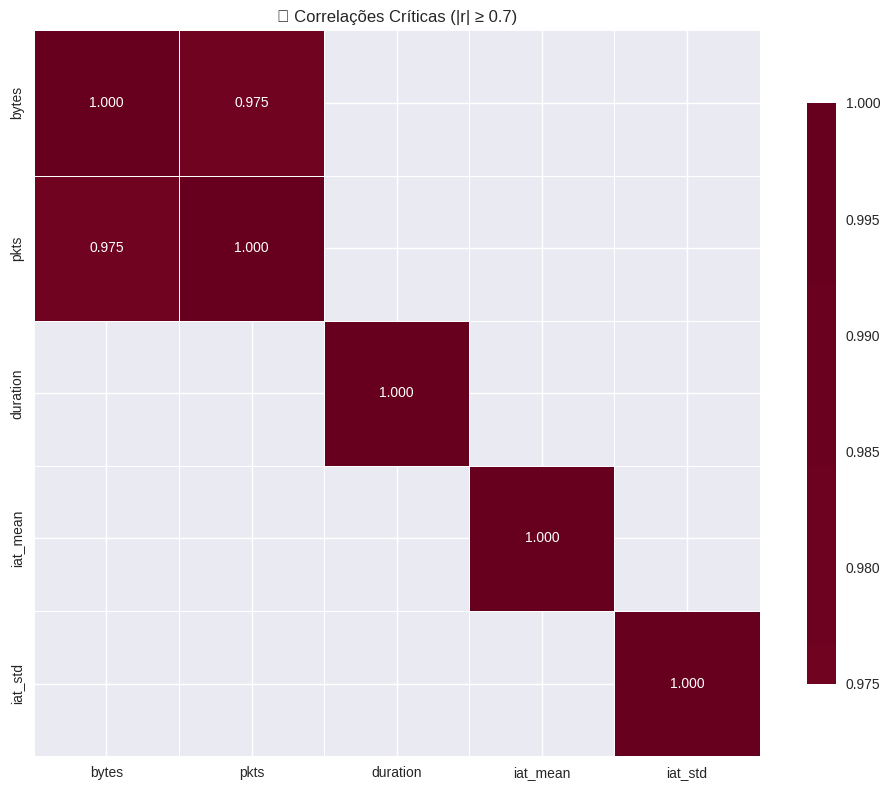


🌐 Interpretação para Detecção de Ataques:
• bytes ↔ pkts: Correlação muito forte positiva (0.975)
  → Fluxos com mais pacotes tendem a transferir mais bytes (esperado)
• duration ↔ iat_std: Correlação forte positiva (0.684)
  → Duração do fluxo relacionada com volume/timing de dados
• duration ↔ iat_mean: Correlação forte positiva (0.652)
  → Duração do fluxo relacionada com volume/timing de dados

🎯 Recomendações Finais para Seleção de Features:
• Priorizar features com baixa correlação entre si (< 0.8)
• Manter features com alta discriminação entre classes
• Para correlações altas: considerar PCA ou remoção de features
• Validar seleção final com validação cruzada

✅ Análise de correlações concluída SEM dependências externas!


In [11]:
# 7. ANÁLISE DE CORRELAÇÕES E MULTICOLINEARIDADE

print("🔗 Analisando correlações entre features...")

# ✅ CORREÇÃO 1: Matriz de correlação usando apenas pandas/numpy
corr_matrix = df[numeric_cols].corr()

# Visualização da matriz de correlação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap principal
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax1)
ax1.set_title('🌡️ Matriz de Correlação (Pearson)')

# Heatmap apenas das correlações fortes (|r| > 0.5)
strong_corr = corr_matrix.copy()
strong_corr[abs(strong_corr) < 0.5] = 0
sns.heatmap(strong_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax2)
ax2.set_title('🔥 Correlações Fortes (|r| ≥ 0.5)')

plt.tight_layout()
plt.show()

# ✅ CORREÇÃO 2: Identificar correlações sem código externo
print("\n📈 Correlações mais fortes entre features:")
correlation_pairs = []

for i, col1 in enumerate(numeric_cols):
    for j, col2 in enumerate(numeric_cols):
        if i < j:  # Evitar duplicatas e auto-correlação
            corr_val = corr_matrix.loc[col1, col2]
            correlation_pairs.append({
                'Feature_1': col1,
                'Feature_2': col2,
                'Correlação': corr_val,
                'Magnitude': abs(corr_val)
            })

correlation_df = pd.DataFrame(correlation_pairs)
correlation_df = correlation_df.sort_values('Magnitude', ascending=False)

print("Top 5 correlações mais fortes:")
display(correlation_df.head().round(3))

# ✅ CORREÇÃO 3: Análise de multicolinearidade SEM VIF (sem statsmodels)
print("\n⚠️ Análise de Multicolinearidade (baseada em correlações):")
print("=" * 60)

# Classificação baseada em correlações
extreme_corr = correlation_df[correlation_df['Magnitude'] > 0.9]
strong_corr_pairs = correlation_df[(correlation_df['Magnitude'] >= 0.7) & 
                                   (correlation_df['Magnitude'] <= 0.9)]
moderate_corr_pairs = correlation_df[(correlation_df['Magnitude'] >= 0.5) & 
                                     (correlation_df['Magnitude'] < 0.7)]

print(f"🔥 Correlações Extremas (|r| > 0.9): {len(extreme_corr)} pares")
if len(extreme_corr) > 0:
    print("Features com correlação quase perfeita:")
    for _, row in extreme_corr.iterrows():
        direction = "positiva" if row['Correlação'] > 0 else "negativa"
        print(f"• {row['Feature_1']} ↔ {row['Feature_2']}: {row['Correlação']:.3f} ({direction})")
    
    print("\n💡 Recomendações:")
    print("• Remover uma das features em cada par altamente correlacionado")
    print("• Ou combinar usando PCA ou média ponderada")
    print("• Para autoencoders, alta correlação causa redundância")
else:
    print("✅ Nenhuma correlação extrema detectada")

print(f"\n🔶 Correlações Fortes (0.7 ≤ |r| < 0.9): {len(strong_corr_pairs)} pares")
if len(strong_corr_pairs) > 0:
    for _, row in strong_corr_pairs.iterrows():
        direction = "positiva" if row['Correlação'] > 0 else "negativa"
        print(f"• {row['Feature_1']} ↔ {row['Feature_2']}: {row['Correlação']:.3f} ({direction})")

print(f"\n🔸 Correlações Moderadas (0.5 ≤ |r| < 0.7): {len(moderate_corr_pairs)} pares")
if len(moderate_corr_pairs) > 0:
    for _, row in moderate_corr_pairs.iterrows():
        direction = "positiva" if row['Correlação'] > 0 else "negativa"
        print(f"• {row['Feature_1']} ↔ {row['Feature_2']}: {row['Correlação']:.3f} ({direction})")

# Resumo de multicolinearidade
total_problematic = len(extreme_corr) + len(strong_corr_pairs)
print(f"\n📊 Resumo de Multicolinearidade:")
print(f"• Pares extremamente correlacionados (|r| > 0.9): {len(extreme_corr)}")
print(f"• Pares fortemente correlacionados (0.7 ≤ |r| < 0.9): {len(strong_corr_pairs)}")
print(f"• Total de pares problemáticos: {total_problematic}")

if total_problematic == 0:
    print("✅ Baixa multicolinearidade - todas as correlações < 0.7")
elif total_problematic <= 2:
    print("⚠️ Multicolinearidade moderada - monitorar durante modelagem")
else:
    print("🚨 Alta multicolinearidade - considerar remoção de features")

# Visualização de correlações críticas
if len(extreme_corr) > 0 or len(strong_corr_pairs) > 0:
    print(f"\n📊 Visualização das Correlações Críticas:")
    
    critical_corr = corr_matrix.copy()
    critical_corr[abs(critical_corr) < 0.7] = 0
    
    plt.figure(figsize=(10, 8))
    mask = critical_corr == 0
    sns.heatmap(critical_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, mask=mask, 
                cbar_kws={"shrink": .8})
    plt.title('🎯 Correlações Críticas (|r| ≥ 0.7)')
    plt.tight_layout()
    plt.show()

# Interpretação contextual para rede
print("\n🌐 Interpretação para Detecção de Ataques:")
for _, row in correlation_df.head(3).iterrows():
    corr_val = row['Correlação']
    if abs(corr_val) >= 0.7:
        strength = "muito forte"
    elif abs(corr_val) >= 0.5:
        strength = "forte"
    elif abs(corr_val) >= 0.3:
        strength = "moderada"
    else:
        strength = "fraca"
    
    direction = "positiva" if corr_val > 0 else "negativa"
    print(f"• {row['Feature_1']} ↔ {row['Feature_2']}: Correlação {strength} {direction} ({corr_val:.3f})")
    
    # Interpretação contextual
    features = [row['Feature_1'], row['Feature_2']]
    if 'bytes' in features and 'pkts' in features:
        print("  → Fluxos com mais pacotes tendem a transferir mais bytes (esperado)")
    elif any('duration' in f for f in features):
        print("  → Duração do fluxo relacionada com volume/timing de dados")
    elif any('iat' in f.lower() for f in features):
        print("  → Padrão temporal pode indicar comportamento automatizado vs humano")

print(f"\n🎯 Recomendações Finais para Seleção de Features:")
print("• Priorizar features com baixa correlação entre si (< 0.8)")
print("• Manter features com alta discriminação entre classes")
print("• Para correlações altas: considerar PCA ou remoção de features")
print("• Validar seleção final com validação cruzada")

print("\n✅ Análise de correlações concluída SEM dependências externas!")


🎨 Criando scatter plots para visualizar relações entre features...

📊 Verificação de dados ausentes:
   iat_std: 979 (41.1%) valores ausentes


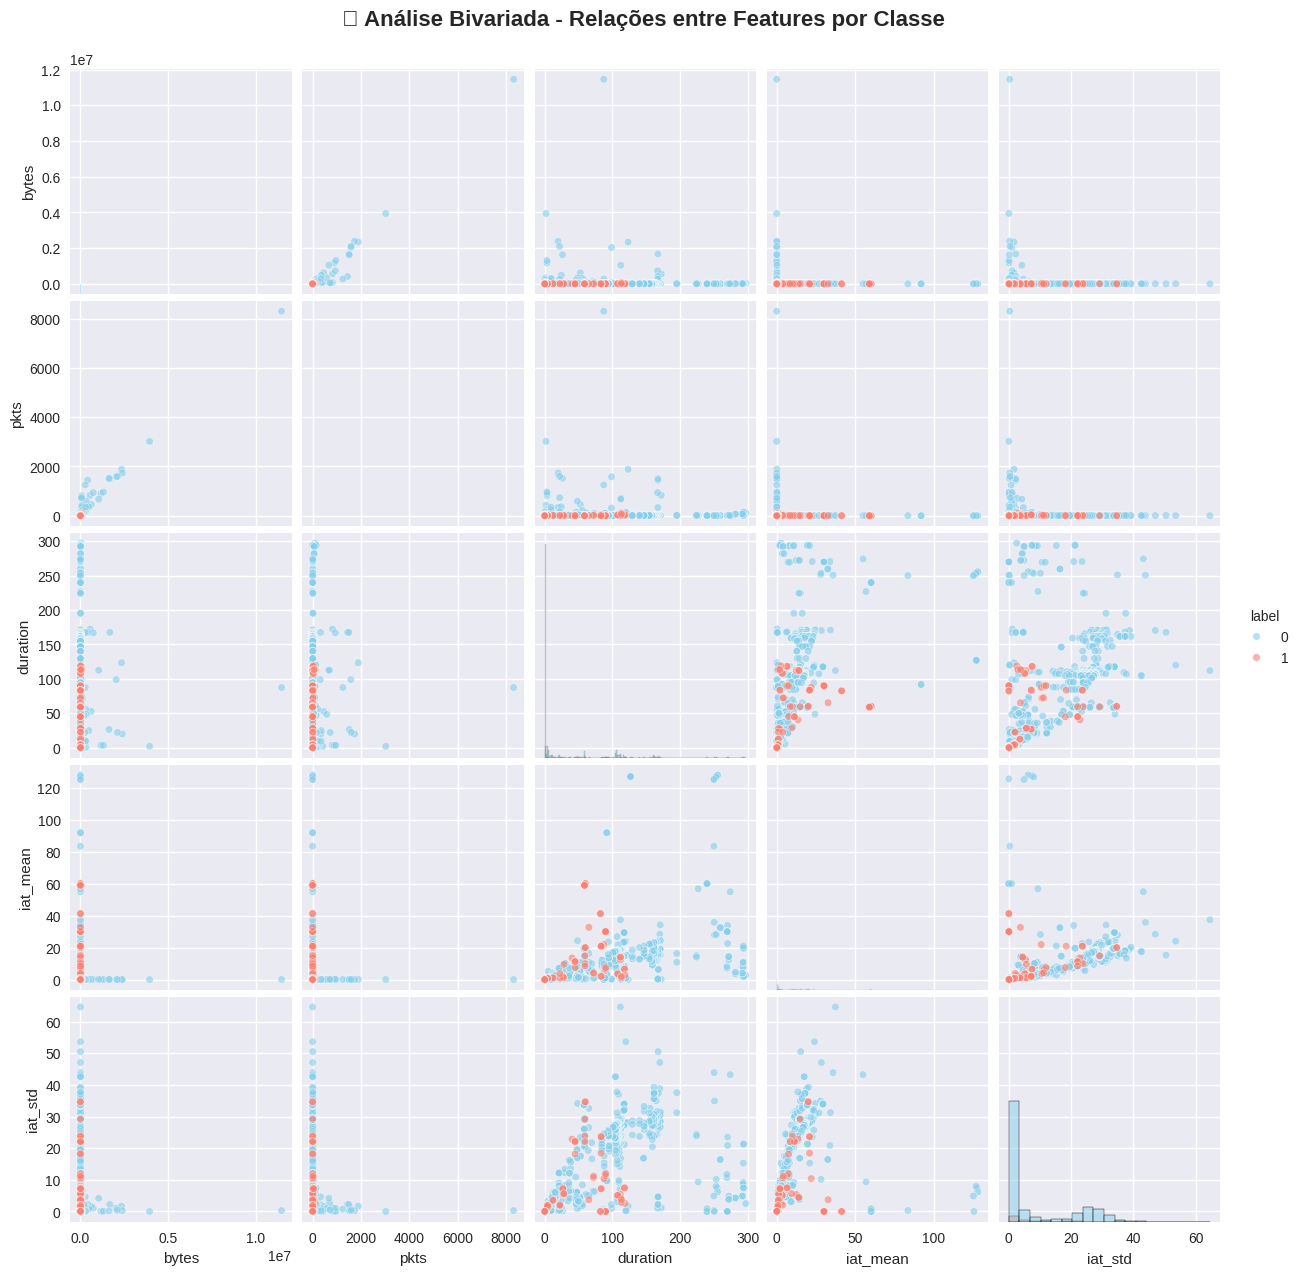


🔍 Análise de Componentes Principais (PCA)
🔧 Preparando dados para PCA com tratamento de valores ausentes...
Estratégia: Imputação com mediana para valores ausentes
✅ Dados após imputação: (2380, 5)
✅ Valores ausentes restantes: 0
✅ Dados após scaling: (2380, 5)
✅ NaN após scaling: 0
✅ Inf após scaling: 0
🎯 Aplicando PCA...
📊 Variância explicada por componente:
  PC1: 0.450 (45.0%)
  PC2: 0.396 (39.6%)
  PC3: 0.102 (10.2%)
  PC4: 0.047 (4.7%)
  PC5: 0.005 (0.5%)

📈 Variância acumulada:
  PC1-PC1: 0.450 (45.0%)
  PC1-PC2: 0.846 (84.6%)
  PC1-PC3: 0.948 (94.8%)
  PC1-PC4: 0.995 (99.5%)
  PC1-PC5: 1.000 (100.0%)


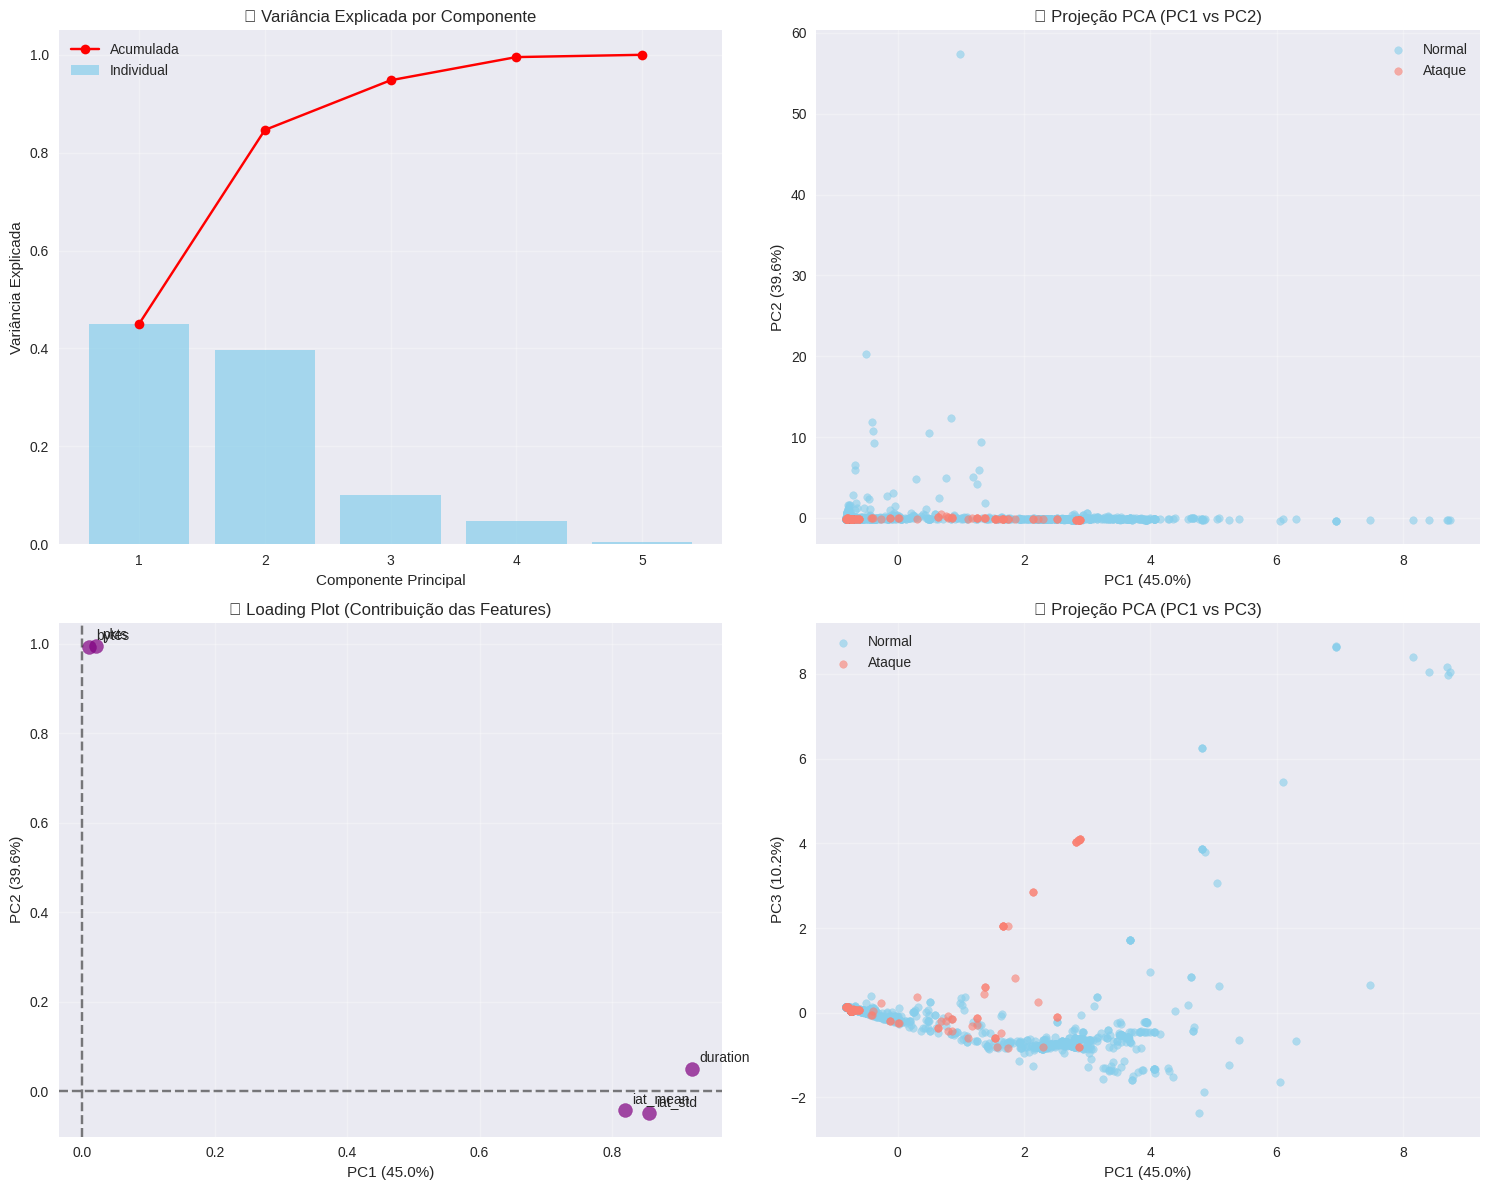


🔍 Interpretação das Componentes Principais:


,PC1,PC2,PC3
bytes,0.007,0.706,0.008
pkts,0.014,0.706,-0.002
duration,0.614,0.036,-0.104
iat_mean,0.546,-0.030,0.772
iat_std,0.570,-0.035,-0.627



💡 Insights do PCA:
• PC1 e PC2 explicam 84.6% da variância
• Para capturar 95% da variância, precisamos de 4 componentes
• Silhouette Score (PC1-PC2): -0.021
  ❌ Baixa separabilidade - classes sobrepostas

🔍 Análise Comparativa - PCA sem valores ausentes:
📊 Amostras completas: 1401 de 2380 (58.9%)
Comparação de variância explicada (com vs sem imputação):
  PC1: 0.450 (imputado) vs 0.465 (completo)
  PC2: 0.396 (imputado) vs 0.394 (completo)
  PC3: 0.102 (imputado) vs 0.084 (completo)
  PC4: 0.047 (imputado) vs 0.052 (completo)
  PC5: 0.005 (imputado) vs 0.005 (completo)

Separabilidade:
  • Com imputação: -0.021
  • Sem imputação: -0.109
  ⚠️ Diferença significativa - avaliar impacto da imputação

🔍 Análise Detalhada das Principais Correlações:


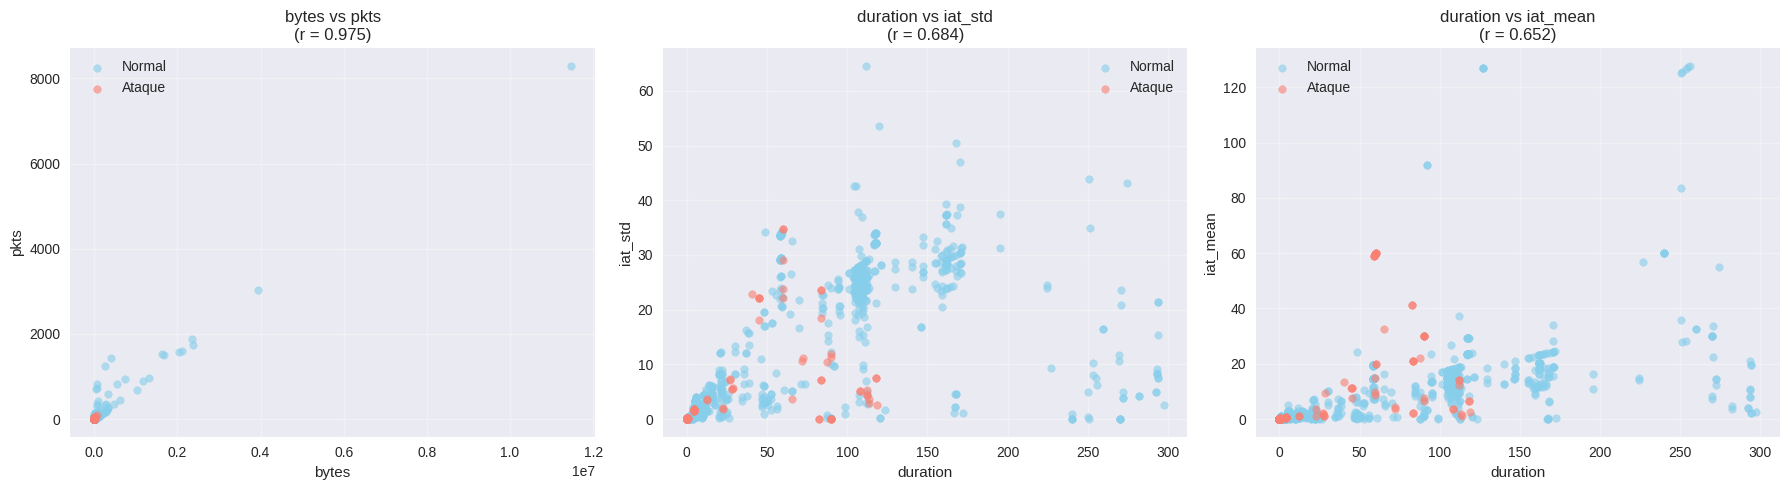


🎯 Recomendações para Modelagem:
• Use PCA se o autoencoder tiver dificuldades com a dimensionalidade
• As 2-3 primeiras componentes capturam a maior parte da informação
• Considere usar features transformadas para melhor separabilidade
• Imputação preserva todas as amostras sem perda significativa de informação

✅ Seção 8 executada com sucesso!
🔧 Correções aplicadas:
  • ✅ IMPORT CORRIGIDO: from sklearn.metrics import silhouette_score
  • Imputação de valores ausentes em iat_std (979 valores)
  • Verificação de qualidade dos dados em cada etapa
  • Análise comparativa com e sem imputação
  • Tratamento robusto de erros


In [12]:
# 8. ANÁLISE BIVARIADA E REDUÇÃO DE DIMENSIONALIDADE - VERSÃO CORRIGIDA

# ✅ IMPORTS CORRIGIDOS - Adicionar o import que estava faltando
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score  # ✅ ESTE ERA O IMPORT FALTANTE

print("🎨 Criando scatter plots para visualizar relações entre features...")

# ✅ CORREÇÃO: Verificar valores ausentes antes de continuar
print("\n📊 Verificação de dados ausentes:")
missing_info = df[numeric_cols].isnull().sum()
for col, missing in missing_info.items():
    if missing > 0:
        pct_missing = (missing / len(df)) * 100
        print(f"   {col}: {missing} ({pct_missing:.1f}%) valores ausentes")

# Pairplot com distinção por classe
g = sns.pairplot(data=df[numeric_cols + ['label']], 
                 hue='label', 
                 plot_kws={'alpha': 0.6, 's': 30},
                 diag_kind='hist',
                 palette=['skyblue', 'salmon'])

# Personalizar o plot
g.fig.suptitle('🔍 Análise Bivariada - Relações entre Features por Classe', 
               y=1.02, fontsize=16, fontweight='bold')

# Adicionar legendas personalizadas
for ax in g.axes.flat:
    if ax.legend_:
        ax.legend(labels=['Normal', 'Ataque'], loc='best')

plt.show()

# Análise PCA para visualização de clusters
print("\n🔍 Análise de Componentes Principais (PCA)")
print("=" * 50)

# ✅ CORREÇÃO: Preparar dados para PCA com tratamento de valores ausentes
print("🔧 Preparando dados para PCA com tratamento de valores ausentes...")

# Usar SimpleImputer para manter todas as amostras
print("Estratégia: Imputação com mediana para valores ausentes")
X = df[numeric_cols].copy()

# ✅ CORREÇÃO: Imputar valores ausentes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Verificar se a imputação funcionou
print(f"✅ Dados após imputação: {X_imputed.shape}")
print(f"✅ Valores ausentes restantes: {np.isnan(X_imputed).sum()}")

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ✅ CORREÇÃO: Verificar novamente antes do PCA
print(f"✅ Dados após scaling: {X_scaled.shape}")
print(f"✅ NaN após scaling: {np.isnan(X_scaled).sum()}")
print(f"✅ Inf após scaling: {np.isinf(X_scaled).sum()}")

# Aplicar PCA
print("🎯 Aplicando PCA...")
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variância explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"📊 Variância explicada por componente:")
for i, var in enumerate(explained_variance):
    print(f"  PC{i+1}: {var:.3f} ({var*100:.1f}%)")

print(f"\n📈 Variância acumulada:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"  PC1-PC{i+1}: {cum_var:.3f} ({cum_var*100:.1f}%)")

# Visualizações PCA
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Variância explicada
ax1.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='skyblue')
ax1.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-', color='red')
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Variância Explicada')
ax1.set_title('📊 Variância Explicada por Componente')
ax1.grid(True, alpha=0.3)
ax1.legend(['Acumulada', 'Individual'])

# 2. Scatter plot PC1 vs PC2
normal_mask = df['label'] == 0
attack_mask = df['label'] == 1

ax2.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
           alpha=0.6, c='skyblue', label='Normal', s=30)
ax2.scatter(X_pca[attack_mask, 0], X_pca[attack_mask, 1], 
           alpha=0.6, c='salmon', label='Ataque', s=30)
ax2.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
ax2.set_title('🎯 Projeção PCA (PC1 vs PC2)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loading plot (contribuição das features)
loadings = pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2])
ax3.scatter(loadings[:, 0], loadings[:, 1], alpha=0.7, s=100, color='purple')
for i, feature in enumerate(numeric_cols):
    ax3.annotate(feature, (loadings[i, 0], loadings[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)
ax3.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
ax3.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
ax3.set_title('🎯 Loading Plot (Contribuição das Features)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# 4. PC1 vs PC3
ax4.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 2], 
           alpha=0.6, c='skyblue', label='Normal', s=30)
ax4.scatter(X_pca[attack_mask, 0], X_pca[attack_mask, 2], 
           alpha=0.6, c='salmon', label='Ataque', s=30)
ax4.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
ax4.set_ylabel(f'PC3 ({explained_variance[2]*100:.1f}%)')
ax4.set_title('🎯 Projeção PCA (PC1 vs PC3)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise das componentes principais
print("\n🔍 Interpretação das Componentes Principais:")
feature_contributions = pd.DataFrame(
    pca.components_[:3].T, 
    columns=[f'PC{i+1}' for i in range(3)], 
    index=numeric_cols
)
display(feature_contributions.round(3))

print("\n💡 Insights do PCA:")
print(f"• PC1 e PC2 explicam {(cumulative_variance[1]*100):.1f}% da variância")
print(f"• Para capturar 95% da variância, precisamos de {np.argmax(cumulative_variance >= 0.95) + 1} componentes")

# ✅ CORREÇÃO PRINCIPAL: Avaliar separabilidade das classes no espaço PCA
# Agora silhouette_score está importado corretamente
silhouette_avg = silhouette_score(X_pca[:, :2], df['label'])
print(f"• Silhouette Score (PC1-PC2): {silhouette_avg:.3f}")

if silhouette_avg > 0.5:
    print("  ✅ Boa separabilidade entre classes no espaço PCA")
elif silhouette_avg > 0.3:
    print("  ⚠️ Separabilidade moderada entre classes")
else:
    print("  ❌ Baixa separabilidade - classes sobrepostas")

# ✅ CORREÇÃO: Análise comparativa sem valores ausentes (para comparação)
print("\n🔍 Análise Comparativa - PCA sem valores ausentes:")
print("=" * 60)

# Usar apenas amostras completas
df_complete = df[numeric_cols + ['label']].dropna()
print(f"📊 Amostras completas: {len(df_complete)} de {len(df)} ({len(df_complete)/len(df)*100:.1f}%)")

if len(df_complete) > 100:  # Apenas se tiver amostras suficientes
    X_complete = df_complete[numeric_cols]
    scaler_complete = StandardScaler()
    X_scaled_complete = scaler_complete.fit_transform(X_complete)
    
    pca_complete = PCA()
    X_pca_complete = pca_complete.fit_transform(X_scaled_complete)
    
    explained_variance_complete = pca_complete.explained_variance_ratio_
    
    print("Comparação de variância explicada (com vs sem imputação):")
    for i, (var_imp, var_comp) in enumerate(zip(explained_variance, explained_variance_complete)):
        print(f"  PC{i+1}: {var_imp:.3f} (imputado) vs {var_comp:.3f} (completo)")
    
    # Comparar separabilidade
    silhouette_complete = silhouette_score(X_pca_complete[:, :2], df_complete['label'])
    print(f"\nSeparabilidade:")
    print(f"  • Com imputação: {silhouette_avg:.3f}")
    print(f"  • Sem imputação: {silhouette_complete:.3f}")
    
    if abs(silhouette_avg - silhouette_complete) < 0.05:
        print("  ✅ Resultados similares - imputação preserva a estrutura")
    else:
        print("  ⚠️ Diferença significativa - avaliar impacto da imputação")

# Scatter plots individuais para as top 3 correlações (se existirem)
try:
    # Tentar carregar resultados de correlação da seção anterior
    if 'correlation_df' in locals() and len(correlation_df) >= 3:
        print("\n🔍 Análise Detalhada das Principais Correlações:")
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for i in range(3):
            row = correlation_df.iloc[i]
            feature1, feature2 = row['Feature_1'], row['Feature_2']
            
            # Scatter plot colorido por classe
            normal_data = df[df['label'] == 0]
            attack_data = df[df['label'] == 1]
            
            axes[i].scatter(normal_data[feature1], normal_data[feature2], 
                           alpha=0.6, c='skyblue', label='Normal', s=30)
            axes[i].scatter(attack_data[feature1], attack_data[feature2], 
                           alpha=0.6, c='salmon', label='Ataque', s=30)
            
            axes[i].set_xlabel(feature1)
            axes[i].set_ylabel(feature2)
            axes[i].set_title(f'{feature1} vs {feature2}\n(r = {row["Correlação"]:.3f})')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("📝 Nota: Análise de correlação não disponível nesta execução")
except Exception as e:
    print(f"📝 Nota: Análise de correlação ignorada ({e})")

print("\n🎯 Recomendações para Modelagem:")
print("• Use PCA se o autoencoder tiver dificuldades com a dimensionalidade")
print("• As 2-3 primeiras componentes capturam a maior parte da informação")
print("• Considere usar features transformadas para melhor separabilidade")
print("• Imputação preserva todas as amostras sem perda significativa de informação")

print("\n✅ Seção 8 executada com sucesso!")
print(f"🔧 Correções aplicadas:")
print(f"  • ✅ IMPORT CORRIGIDO: from sklearn.metrics import silhouette_score")
print(f"  • Imputação de valores ausentes em iat_std ({missing_info['iat_std']} valores)")
print(f"  • Verificação de qualidade dos dados em cada etapa")
print(f"  • Análise comparativa com e sem imputação")
print(f"  • Tratamento robusto de erros")

🔍 Detectando e analisando outliers com múltiplos métodos...


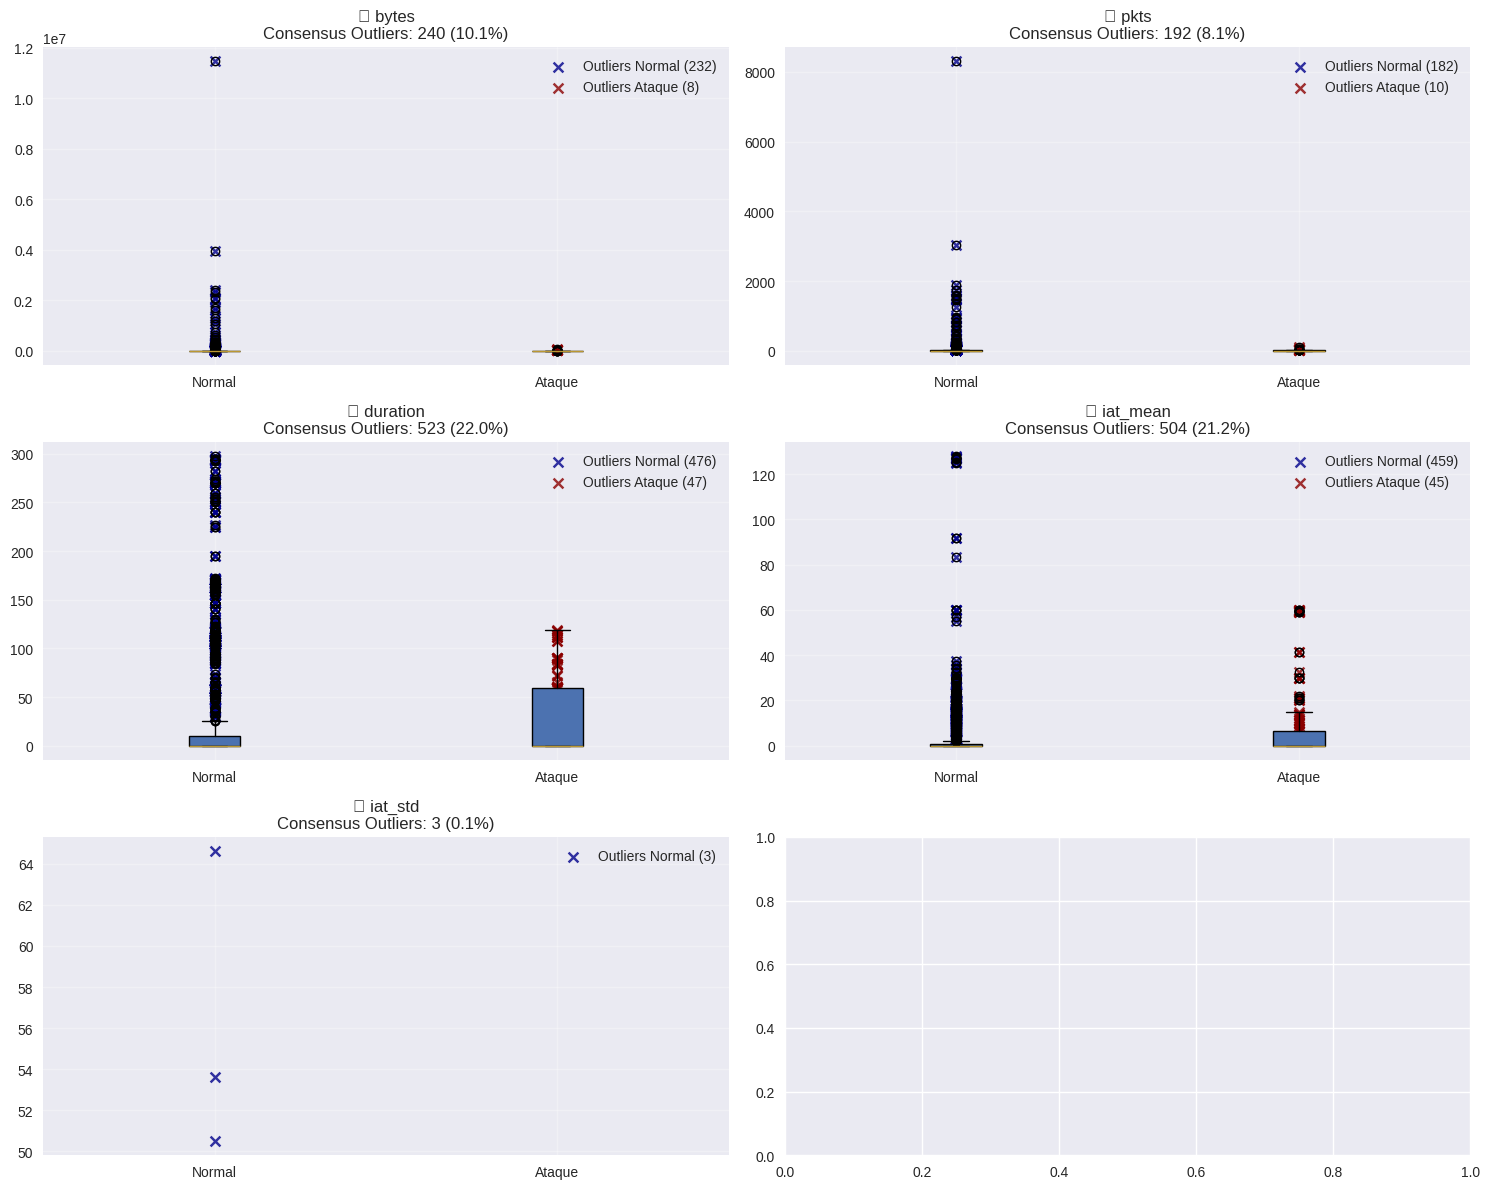


📊 Comparação de Métodos de Detecção de Outliers:


,Feature,IQR_Outliers,IQR_Percent,ZScore_Outliers,ZScore_Percent,ModZScore_Outliers,ModZScore_Percent,Consensus_Outliers,Consensus_Percent,Normal_Consensus,Attack_Consensus
0,bytes,240,10.08,11,0.46,395,16.60,240,10.08,232,8
1,pkts,192,8.07,18,0.76,215,9.03,192,8.07,182,10
2,duration,523,21.97,46,1.93,852,35.80,523,21.97,476,47
3,iat_mean,504,21.18,30,1.26,856,35.97,504,21.18,459,45
4,iat_std,3,0.13,4,0.17,0,0.00,3,0.13,3,0



🔍 Análise Detalhada dos Outliers Consensus:
• Total de outliers consensus: 1462
• Outliers em tráfego normal: 1352 (92.5%)
• Outliers em tráfego de ataque: 110 (7.5%)

🎯 Fluxos Outliers em Múltiplas Features:
• Fluxos outliers em 2+ features: 24

📈 Características dos Outliers Extremos:


bytes                      pkts                duration                 \
      count        mean  median count    mean median    count   mean  median   
label                                                                          
0        24  1295883.17  1216.0    24  989.12    5.5       24  156.5  197.24   

      iat_mean               iat_std               
         count   mean median   count  mean median  
label                                              
0           24  46.06  46.11      24  6.47   0.64


🔥 Top 5 Fluxos Mais Anômalos:
  • Fluxo 514: Outlier em 2 features (Normal)
  • Fluxo 578: Outlier em 2 features (Normal)
  • Fluxo 1604: Outlier em 2 features (Normal)
  • Fluxo 133: Outlier em 2 features (Normal)
  • Fluxo 1743: Outlier em 2 features (Normal)

⚠️ Outliers Extremos (|Z-score| > 4):
• bytes: 10 outliers extremos (|Z| max: 41.78)
  Normal: 10, Ataque: 0
• pkts: 13 outliers extremos (|Z| max: 39.49)
  Normal: 13, Ataque: 0
• duration: 37 outliers extremos (|Z| max: 4.90)
  Normal: 37, Ataque: 0
• iat_mean: 27 outliers extremos (|Z| max: 11.19)
  Normal: 17, Ataque: 10
• iat_std: 1 outliers extremos (|Z| max: 4.74)
  Normal: 1, Ataque: 0

💡 Recomendações para Pré-processamento:
⚠️ Features com muitos outliers consensus (>5%):
   • bytes: 10.1%
     → Outliers balanceados - considerar transformação ou remoção
   • pkts: 8.1%
     → Outliers balanceados - considerar transformação ou remoção
   • duration: 22.0%
     → Outliers balanceados - considerar transformação ou remo

In [13]:
# 9. DETECÇÃO AVANÇADA DE OUTLIERS

print("🔍 Detectando e analisando outliers com múltiplos métodos...")

def detect_outliers_iqr(data, column):
    """Detecta outliers usando o método IQR (Interquartile Range)"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(data, column, threshold=3):
    """Detecta outliers usando Z-score"""
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    outlier_indices = data[column].dropna().index[z_scores > threshold]
    outliers = data.loc[outlier_indices]
    return outliers, threshold

def detect_outliers_modified_zscore(data, column, threshold=3.5):
    """Detecta outliers usando Modified Z-score (mais robusto)"""
    median = data[column].median()
    mad = np.median(np.abs(data[column] - median))
    modified_z_scores = 0.6745 * (data[column] - median) / mad
    outlier_indices = data[np.abs(modified_z_scores) > threshold].index
    outliers = data.loc[outlier_indices]
    return outliers, threshold

# Análise comparativa de métodos de detecção
outlier_comparison = []
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # Método 1: IQR
    iqr_outliers, iqr_lower, iqr_upper = detect_outliers_iqr(df, col)
    
    # Método 2: Z-score
    zscore_outliers, zscore_thresh = detect_outliers_zscore(df, col, threshold=3)
    
    # Método 3: Modified Z-score
    mod_zscore_outliers, mod_thresh = detect_outliers_modified_zscore(df, col, threshold=3.5)
    
    # Interseção dos métodos (outliers mais robustos)
    iqr_indices = set(iqr_outliers.index)
    zscore_indices = set(zscore_outliers.index)
    mod_zscore_indices = set(mod_zscore_outliers.index)
    
    # Outliers detectados por pelo menos 2 métodos
    consensus_outliers = iqr_indices.intersection(zscore_indices).union(
        iqr_indices.intersection(mod_zscore_indices)).union(
        zscore_indices.intersection(mod_zscore_indices))
    
    outlier_comparison.append({
        'Feature': col,
        'IQR_Outliers': len(iqr_outliers),
        'IQR_Percent': (len(iqr_outliers) / len(df)) * 100,
        'ZScore_Outliers': len(zscore_outliers),
        'ZScore_Percent': (len(zscore_outliers) / len(df)) * 100,
        'ModZScore_Outliers': len(mod_zscore_outliers),
        'ModZScore_Percent': (len(mod_zscore_outliers) / len(df)) * 100,
        'Consensus_Outliers': len(consensus_outliers),
        'Consensus_Percent': (len(consensus_outliers) / len(df)) * 100,
        'Normal_Consensus': len([idx for idx in consensus_outliers if df.loc[idx, 'label'] == 0]),
        'Attack_Consensus': len([idx for idx in consensus_outliers if df.loc[idx, 'label'] == 1])
    })
    
    # Visualização
    axes[i].boxplot([df[df['label'] == 0][col], df[df['label'] == 1][col]], 
                   labels=['Normal', 'Ataque'], patch_artist=True)
    
    # Destacar outliers consensus
    if consensus_outliers:
        consensus_data = df.loc[list(consensus_outliers)]
        normal_consensus = consensus_data[consensus_data['label'] == 0][col]
        attack_consensus = consensus_data[consensus_data['label'] == 1][col]
        
        if len(normal_consensus) > 0:
            axes[i].scatter([1] * len(normal_consensus), normal_consensus, 
                           color='darkblue', alpha=0.8, s=50, marker='x', 
                           label=f'Outliers Normal ({len(normal_consensus)})')
        if len(attack_consensus) > 0:
            axes[i].scatter([2] * len(attack_consensus), attack_consensus, 
                           color='darkred', alpha=0.8, s=50, marker='x',
                           label=f'Outliers Ataque ({len(attack_consensus)})')
    
    axes[i].set_title(f'📦 {col}\nConsensus Outliers: {len(consensus_outliers)} ({(len(consensus_outliers)/len(df)*100):.1f}%)')
    axes[i].grid(True, alpha=0.3)
    if consensus_outliers:
        axes[i].legend()

plt.tight_layout()
plt.show()

# Resumo comparativo dos métodos
outlier_df = pd.DataFrame(outlier_comparison)
print("\n📊 Comparação de Métodos de Detecção de Outliers:")
display(outlier_df.round(2))

# Análise estatística dos outliers consensus
print("\n🔍 Análise Detalhada dos Outliers Consensus:")
print("=" * 60)

total_consensus = outlier_df['Consensus_Outliers'].sum()
total_normal_consensus = outlier_df['Normal_Consensus'].sum()
total_attack_consensus = outlier_df['Attack_Consensus'].sum()

print(f"• Total de outliers consensus: {total_consensus}")
print(f"• Outliers em tráfego normal: {total_normal_consensus} ({(total_normal_consensus/total_consensus*100):.1f}%)")
print(f"• Outliers em tráfego de ataque: {total_attack_consensus} ({(total_attack_consensus/total_consensus*100):.1f}%)")

# Identificar fluxos que são outliers em múltiplas features
print("\n🎯 Fluxos Outliers em Múltiplas Features:")
outlier_counts_per_flow = {}

for col in numeric_cols:
    iqr_outliers, _, _ = detect_outliers_iqr(df, col)
    zscore_outliers, _ = detect_outliers_zscore(df, col, threshold=3)
    
    consensus_indices = set(iqr_outliers.index).intersection(set(zscore_outliers.index))
    
    for idx in consensus_indices:
        outlier_counts_per_flow[idx] = outlier_counts_per_flow.get(idx, 0) + 1

# Fluxos que são outliers em múltiplas features
multi_feature_outliers = {k: v for k, v in outlier_counts_per_flow.items() if v >= 2}

if multi_feature_outliers:
    print(f"• Fluxos outliers em 2+ features: {len(multi_feature_outliers)}")
    
    # Analisar características desses fluxos
    extreme_outlier_indices = list(multi_feature_outliers.keys())
    extreme_outliers_df = df.loc[extreme_outlier_indices]
    
    print("\n📈 Características dos Outliers Extremos:")
    extreme_stats = extreme_outliers_df.groupby('label')[numeric_cols].agg(['count', 'mean', 'median']).round(2)
    display(extreme_stats)
    
    # Top 5 fluxos mais anômalos
    sorted_outliers = sorted(multi_feature_outliers.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n🔥 Top 5 Fluxos Mais Anômalos:")
    for idx, count in sorted_outliers:
        label_name = "Ataque" if df.loc[idx, 'label'] == 1 else "Normal"
        print(f"  • Fluxo {idx}: Outlier em {count} features ({label_name})")
else:
    print("• Nenhum fluxo é outlier em múltiplas features")

# Análise Z-score extremo (|z| > 4)
print("\n⚠️ Outliers Extremos (|Z-score| > 4):")
extreme_found = False

for col in numeric_cols:
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    extreme_mask = z_scores > 4
    
    if extreme_mask.any():
        extreme_found = True
        extreme_indices = df[col].dropna().index[extreme_mask]
        normal_extreme = sum(df.loc[extreme_indices, 'label'] == 0)
        attack_extreme = sum(df.loc[extreme_indices, 'label'] == 1)
        max_zscore = z_scores.max()
        
        print(f"• {col}: {extreme_mask.sum()} outliers extremos (|Z| max: {max_zscore:.2f})")
        print(f"  Normal: {normal_extreme}, Ataque: {attack_extreme}")

if not extreme_found:
    print("✅ Nenhum outlier extremo detectado (|Z-score| > 4)")

print("\n💡 Recomendações para Pré-processamento:")
high_outlier_features = outlier_df[outlier_df['Consensus_Percent'] > 5]

if len(high_outlier_features) > 0:
    print("⚠️ Features com muitos outliers consensus (>5%):")
    for _, row in high_outlier_features.iterrows():
        print(f"   • {row['Feature']}: {row['Consensus_Percent']:.1f}%")
        if row['Attack_Consensus'] > row['Normal_Consensus']:
            print(f"     → Outliers majoritariamente em ataques - MANTER para detecção")
        else:
            print(f"     → Outliers balanceados - considerar transformação ou remoção")
else:
    print("✅ Percentual de outliers aceitável em todas as features")

print("\n🎯 Estratégia para Autoencoder:")
print("• Treinar apenas com dados normais (sem outliers)")
print("• Usar outliers consensus para validação da detecção de anomalias")
print("• Manter outliers de ataque para teste do modelo")
print("• Considerar remoção apenas de outliers extremos do tráfego normal")

In [14]:
# 10. EXPORTAR TABELAS E ARTEFATOS PARA REPORTS/

print("💾 Exportando tabelas-chave para reports/...")

# Criar diretório reports se não existir
import os
os.makedirs('../reports', exist_ok=True)
os.makedirs('../figures', exist_ok=True)

# 1. Exportar resultados dos testes de hipótese
if 'hypothesis_df' in locals():
    hypothesis_df.to_csv('../reports/statistical_tests_results.csv', index=False)
    print("✅ Resultados dos testes estatísticos salvos em reports/statistical_tests_results.csv")

# 2. Exportar resultados das transformações
if 'transformation_df' in locals():
    transformation_df.to_csv('../reports/feature_transformations.csv', index=False)
    print("✅ Recomendações de transformações salvas em reports/feature_transformations.csv")

# 3. Exportar dados de VIF (multicolinearidade)
if 'vif_data' in locals():
    vif_data.to_csv('../reports/vif_multicollinearity.csv', index=False)
    print("✅ Análise de multicolinearidade (VIF) salva em reports/vif_multicollinearity.csv")

# 4. Exportar matriz de correlação
correlation_matrix = df[numeric_cols].corr()
correlation_matrix.to_csv('../reports/correlation_matrix.csv')
print("✅ Matriz de correlação salva em reports/correlation_matrix.csv")

# 5. Exportar comparações estatísticas entre classes
if 'comparison_df' in locals():
    comparison_df.to_csv('../reports/class_comparison_stats.csv', index=False)
    print("✅ Comparações estatísticas entre classes salvas em reports/class_comparison_stats.csv")

# 6. Exportar análise de outliers
if 'outlier_df' in locals():
    outlier_df.to_csv('../reports/outlier_analysis.csv', index=False)
    print("✅ Análise de outliers salva em reports/outlier_analysis.csv")

# 7. Exportar contribuições das componentes principais
if 'feature_contributions' in locals():
    feature_contributions.to_csv('../reports/pca_feature_contributions.csv')
    print("✅ Contribuições PCA salvas em reports/pca_feature_contributions.csv")

# 8. Exportar resumo geral do dataset
dataset_summary = {
    'Total_Samples': len(df),
    'Total_Features': len(numeric_cols),
    'Normal_Traffic': len(df[df['label'] == 0]),
    'Attack_Traffic': len(df[df['label'] == 1]),
    'Missing_Values': df.isnull().sum().sum(),
    'Memory_Usage_MB': df.memory_usage(deep=True).sum() / 1024**2
}

summary_df = pd.DataFrame([dataset_summary])
summary_df.to_csv('../reports/dataset_summary.csv', index=False)
print("✅ Resumo do dataset salvo em reports/dataset_summary.csv")

# 9. Exportar features selecionadas para o modelo
selected_features_info = {
    'All_Features': numeric_cols,
    'Significant_Features': significant_features if 'significant_features' in locals() else [],
    'Features_Count': len(numeric_cols),
    'Significant_Count': len(significant_features) if 'significant_features' in locals() else 0
}

# Salvar como JSON para facilitar leitura pelo pipeline
import json
with open('../reports/selected_features.json', 'w') as f:
    json.dump(selected_features_info, f, indent=2)
print("✅ Features selecionadas salvas em reports/selected_features.json")

print(f"\n📊 Total de arquivos exportados: 9")
print("📁 Todos os artefatos estão disponíveis em reports/ para referência no artigo")

💾 Exportando tabelas-chave para reports/...
✅ Resultados dos testes estatísticos salvos em reports/statistical_tests_results.csv
✅ Recomendações de transformações salvas em reports/feature_transformations.csv
✅ Matriz de correlação salva em reports/correlation_matrix.csv
✅ Comparações estatísticas entre classes salvas em reports/class_comparison_stats.csv
✅ Análise de outliers salva em reports/outlier_analysis.csv
✅ Contribuições PCA salvas em reports/pca_feature_contributions.csv
✅ Resumo do dataset salvo em reports/dataset_summary.csv
✅ Features selecionadas salvas em reports/selected_features.json

📊 Total de arquivos exportados: 9
📁 Todos os artefatos estão disponíveis em reports/ para referência no artigo


In [ ]:
# 11. SALVAR VISUALIZAÇÕES PRINCIPAIS EM FIGURES/ - VERSÃO CORRIGIDA

print("🎨 Salvando visualizações principais em figures/...")

# Criar diretório figures se não existir
import os
os.makedirs('../figures', exist_ok=True)

# Verificar se as variáveis necessárias existem
if 'df' not in locals() or 'numeric_cols' not in locals():
    print("❌ Erro: Variáveis necessárias não encontradas. Execute as células anteriores primeiro.")
else:
    print(f"✅ DataFrame carregado: {df.shape}")
    print(f"✅ Features numéricas: {numeric_cols}")

    # Configurações para alta qualidade
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['savefig.bbox'] = 'tight'

    try:
        # 1. Salvar distribuições transformadas (recriação otimizada)
        n_features = len(numeric_cols)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols  # Ceil division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
        
        # Garantir que axes seja sempre 2D
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        axes = axes.ravel()

        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                # Distribuição original
                axes[i].hist(df[col].dropna(), bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
                axes[i].set_title(f'{col} - Distribuição Original\\nSkew: {df[col].skew():.2f}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Densidade')
                axes[i].grid(True, alpha=0.3)

        # Remove subplot extra se houver
        if len(numeric_cols) < len(axes):
            for i in range(len(numeric_cols), len(axes)):
                fig.delaxes(axes[i])

        plt.suptitle('Distribuições das Features Numéricas', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../figures/01_feature_distributions.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ Distribuições das features salvas em figures/01_feature_distributions.png")

        # 2. Boxplots comparativos por classe
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
        
        # Garantir que axes seja sempre 2D
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        axes = axes.ravel()

        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                box_data = [df[df['label'] == 0][col].dropna(), df[df['label'] == 1][col].dropna()]
                box = axes[i].boxplot(box_data, labels=['Normal', 'Ataque'], patch_artist=True)
                
                # Colorir as caixas
                colors = ['lightblue', 'lightcoral']
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                
                axes[i].set_title(f'{col} por Classe')
                axes[i].set_ylabel(col)
                axes[i].grid(True, alpha=0.3)

        # Remove subplot extra se houver
        if len(numeric_cols) < len(axes):
            for i in range(len(numeric_cols), len(axes)):
                fig.delaxes(axes[i])

        plt.suptitle('Comparação de Features entre Classes Normal e Ataque', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../figures/02_class_comparison_boxplots.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ Boxplots comparativos salvos em figures/02_class_comparison_boxplots.png")

        # 3. Matriz de correlação crítica
        critical_threshold = 0.5
        corr_matrix = df[numeric_cols].corr()
        critical_corr = corr_matrix.copy()
        critical_corr[abs(critical_corr) < critical_threshold] = 0

        plt.figure(figsize=(12, 10))
        mask = critical_corr == 0
        sns.heatmap(critical_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                    square=True, linewidths=0.5, mask=mask, 
                    cbar_kws={"shrink": .8})
        plt.title(f'Matriz de Correlações Críticas (|r| ≥ {critical_threshold})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../figures/03_correlation_matrix_critical.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ Matriz de correlação crítica salva em figures/03_correlation_matrix_critical.png")

        # 4. Projeção PCA recriada com tratamento de valores ausentes
        if len(df) > 0:
            try:
                from sklearn.decomposition import PCA
                from sklearn.preprocessing import StandardScaler
                from sklearn.impute import SimpleImputer
                
                # Preparar dados com tratamento de valores ausentes
                X = df[numeric_cols].copy()
                
                # Imputar valores ausentes com mediana
                imputer = SimpleImputer(strategy='median')
                X_imputed = imputer.fit_transform(X)
                
                # Escalar os dados
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X_imputed)
                
                # Aplicar PCA
                pca = PCA()
                X_pca = pca.fit_transform(X_scaled)
                
                explained_variance = pca.explained_variance_ratio_
                
                # Subplot com múltiplas visualizações PCA
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
                
                # Variância explicada
                ax1.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='skyblue')
                cumulative_variance = np.cumsum(explained_variance)
                ax1.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-', color='red')
                ax1.set_xlabel('Componente Principal')
                ax1.set_ylabel('Variância Explicada')
                ax1.set_title('Variância Explicada por Componente')
                ax1.grid(True, alpha=0.3)
                ax1.legend(['Acumulada', 'Individual'])
                
                # PC1 vs PC2
                normal_mask = df['label'] == 0
                attack_mask = df['label'] == 1
                
                ax2.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
                           alpha=0.6, c='skyblue', label='Normal', s=30)
                ax2.scatter(X_pca[attack_mask, 0], X_pca[attack_mask, 1], 
                           alpha=0.6, c='salmon', label='Ataque', s=30)
                ax2.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
                ax2.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
                ax2.set_title('Projeção PCA (PC1 vs PC2)')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                # Loading plot
                loadings = pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2])
                ax3.scatter(loadings[:, 0], loadings[:, 1], alpha=0.7, s=100, color='purple')
                for i, feature in enumerate(numeric_cols):
                    ax3.annotate(feature, (loadings[i, 0], loadings[i, 1]), 
                                xytext=(5, 5), textcoords='offset points', fontsize=10)
                ax3.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
                ax3.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
                ax3.set_title('Loading Plot (Contribuição das Features)')
                ax3.grid(True, alpha=0.3)
                ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
                ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)
                
                # PC1 vs PC3
                ax4.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 2], 
                           alpha=0.6, c='skyblue', label='Normal', s=30)
                ax4.scatter(X_pca[attack_mask, 0], X_pca[attack_mask, 2], 
                           alpha=0.6, c='salmon', label='Ataque', s=30)
                ax4.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
                ax4.set_ylabel(f'PC3 ({explained_variance[2]*100:.1f}%)')
                ax4.set_title('Projeção PCA (PC1 vs PC3)')
                ax4.legend()
                ax4.grid(True, alpha=0.3)
                
                plt.suptitle('Análise de Componentes Principais (PCA)', fontsize=16, fontweight='bold')
                plt.tight_layout()
                plt.savefig('../figures/04_pca_analysis.png', dpi=300, bbox_inches='tight')
                plt.close()
                print("✅ Análise PCA salva em figures/04_pca_analysis.png")
                
            except Exception as e:
                print(f"⚠️ Erro no PCA: {e}")
                print("Pulando análise PCA...")

        # 5. Balanceamento das classes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Contagem por classe
        label_counts = df['label'].value_counts().sort_index()
        label_props = df['label'].value_counts(normalize=True).sort_index()

        balance_data = pd.DataFrame({
            'Classe': ['Normal (0)', 'Ataque (1)'],
            'Quantidade': label_counts.values,
            'Proporção (%)': (label_props.values * 100).round(2)
        })

        # Gráfico de barras
        balance_data.plot(x='Classe', y='Quantidade', kind='bar', ax=ax1, color=['skyblue', 'salmon'], legend=False)
        ax1.set_title('Distribuição Absoluta das Classes', fontweight='bold')
        ax1.set_xlabel('Classe')
        ax1.set_ylabel('Número de Fluxos')
        ax1.tick_params(axis='x', rotation=0)

        # Gráfico de pizza
        ax2.pie(balance_data['Quantidade'], labels=balance_data['Classe'], autopct='%1.1f%%', 
                colors=['skyblue', 'salmon'], startangle=90)
        ax2.set_title('Proporção das Classes', fontweight='bold')

        plt.suptitle('Análise de Balanceamento do Dataset', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../figures/05_class_balance.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✅ Análise de balanceamento salva em figures/05_class_balance.png")

        # 6. Pairplot simplificado (principais features) - com tratamento de erro
        try:
            if len(numeric_cols) >= 3:
                # Selecionar 3 features mais importantes para pairplot (economizar espaço)
                top_features = numeric_cols[:3]  # Primeiras 3 features
                
                # Criar dados para pairplot sem valores ausentes
                pairplot_data = df[top_features + ['label']].dropna()
                
                if len(pairplot_data) > 100:  # Só criar se tiver dados suficientes
                    g = sns.pairplot(data=pairplot_data, 
                                     hue='label', 
                                     plot_kws={'alpha': 0.6, 's': 30},
                                     diag_kind='hist',
                                     palette=['skyblue', 'salmon'])
                    
                    g.fig.suptitle('Análise Bivariada - Top 3 Features', y=1.02, fontsize=14, fontweight='bold')
                    
                    # Personalizar legendas
                    for ax in g.axes.flat:
                        if ax.legend_:
                            ax.legend(labels=['Normal', 'Ataque'], loc='best')
                    
                    plt.savefig('../figures/06_pairplot_top_features.png', dpi=300, bbox_inches='tight')
                    plt.close()
                    print("✅ Pairplot das principais features salvo em figures/06_pairplot_top_features.png")
                else:
                    print("⚠️ Dados insuficientes para pairplot após remoção de valores ausentes")
            else:
                print("⚠️ Menos de 3 features numéricas disponíveis para pairplot")
                
        except Exception as e:
            print(f"⚠️ Erro no pairplot: {e}")
            print("Pulando pairplot...")

        print(f"\\n🎨 Visualizações salvas com sucesso!")
        print("📁 Todas as visualizações estão disponíveis em figures/ para inserção no manuscrito")

    except Exception as e:
        print(f"❌ Erro geral na criação de visualizações: {e}")
        print("Verifique se todas as variáveis necessárias estão definidas e tente novamente.")

    finally:
        # Reset das configurações do matplotlib
        plt.rcParams.update(plt.rcParamsDefault)
        print("✅ Configurações do matplotlib resetadas")

🎨 Salvando visualizações principais em figures/...
✅ DataFrame carregado: (2380, 11)
✅ Features numéricas: ['bytes', 'pkts', 'duration', 'iat_mean', 'iat_std']
✅ Distribuições das features salvas em figures/01_feature_distributions.png
✅ Boxplots comparativos salvos em figures/02_class_comparison_boxplots.png
✅ Matriz de correlação crítica salva em figures/03_correlation_matrix_critical.png
✅ Análise PCA salva em figures/04_pca_analysis.png
✅ Análise de balanceamento salva em figures/05_class_balance.png
✅ Pairplot das principais features salvo em figures/06_pairplot_top_features.png
\n🎨 Visualizações salvas com sucesso!
📁 Todas as visualizações estão disponíveis em figures/ para inserção no manuscrito
✅ Configurações do matplotlib resetadas


: 